# NSynth Dataset

[NSynth](https://magenta.tensorflow.org/datasets/nsynth#files) is "<i>a large-scale and high-quality dataset of annotated musical notes</i>" <br>
[Download](https://magenta.tensorflow.org/datasets/nsynth#files) train, validation, and test data

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import librosa
import librosa.display
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import collections
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Configuration parameters

In [2]:
#Data folder
data_dir='/home/malvarez/TFG2/Instrumentos/DataInput/WaveFiles/'

#Plots folder
plots_dir='/home/malvarez/TFG2/Instrumentos/Plots/01_ExploringWaveFiles/'

#Select  a wave file of each type for the dataset
bass_file = data_dir + 'nsynth-valid/audio/bass_electronic_018-047-075.wav'
brass_file = data_dir + 'nsynth-valid/audio/brass_acoustic_006-031-050.wav'
flute_file = data_dir + 'nsynth-valid/audio/flute_synthetic_000-035-127.wav'
guitar_file = data_dir + 'nsynth-valid/audio/guitar_acoustic_010-086-100.wav'
keyboard_file = data_dir + 'nsynth-valid/audio/keyboard_acoustic_004-041-100.wav'
mallet_file = data_dir + 'nsynth-valid/audio/mallet_acoustic_056-065-050.wav'
organ_file = data_dir + 'nsynth-valid/audio/organ_electronic_007-015-100.wav'
reed_file = data_dir + 'nsynth-valid/audio/reed_acoustic_023-042-127.wav'
string_file = data_dir + 'nsynth-valid/audio/string_acoustic_012-035-100.wav'
synth_lead_file = data_dir + 'nsynth-valid/audio/flute_acoustic_002-093-075.wav'
vocal_file = data_dir + 'nsynth-valid/audio/vocal_synthetic_003-030-050.wav'

## Code version

In [3]:
print('numpy version ',np.__version__)
print('pandas version ',pd.__version__)
print('librosa version ', librosa.__version__)
print('re version ', re.__version__)
print('seaborn version ', sns.__version__)
print('scipy version ', scipy.__version__)

numpy version  1.18.5
pandas version  1.1.2
librosa version  0.8.0
re version  2.2.1
seaborn verrsion  0.11.0
scipy version  1.4.1


# Instruments & Sources
### Instrument index

| Index | ID   |
|------|------|
|   0  | bass|
|   1  | brass|
|   2  | flute|
|   3  | guitar|
|   4  | keyboard|
|   5  | mallet|
|   6  | organ|
|   7  | reed|
|   8  | string|
|   9  | synth_lead|
|   10  | vocal|

### Source Index

| Index | ID   |
|------|------|
|   0  | acoustic|
|   1  | electronic|
|   2  | synthetic|

In [4]:
#Store class names in array
class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
#Store source names in array
source_names=['acoustic', 'electronic', 'synthetic']

# Anatomy of a Wave File

Explore the features of a wave file by picking random samples for each instrument and illustrating the features

### Pick a file

In [5]:
class_names

['bass',
 'brass',
 'flute',
 'guitar',
 'keyboard',
 'mallet',
 'organ',
 'reed',
 'string',
 'synth_lead',
 'vocal']

In [6]:
sample_files = [bass_file, brass_file, flute_file, guitar_file, keyboard_file, 
         mallet_file, organ_file, reed_file, string_file, synth_lead_file, vocal_file]

### Feature Extraction

### Waveform & Sampling Rate: [librosa.core.load](https://librosa.github.io/librosa/generated/librosa.core.load.html)

A sound is a continous time signal that is usually represented by a wave <b>form</b>, this continuous signal is sampled and converted into a discrete time signal. <b>Sample Rate</b> is the number of samples of audio recorded per second. The sample rate determines the maximum audio frequency that can be reproduced, Indeed the maximum frequency that can be represented is half the sample rate. Most humans can hear sounds in the frequency of 20-20,000Hz and so most some sounds like CDs are sampled are 44,000Hz, that is to say in one second the analog signal is sampled 44,100. <br>

Sources:<br>
[Frequency Range of Human Hearing](https://hypertextbook.com/facts/2003/ChrisDAmbrose.shtml)<br>
[7 Questions About Sample Rate](https://www.sweetwater.com/insync/7-things-about-sample-rate/)

In [7]:
#load the audio as waveform y
#store the sampling rate as s
# To preserve the native sampling rate of the file, use sr=None
y= []
sr = []
for file in sample_files:
    y_out, sr_out = librosa.load(file, sr=None)
    y.append(y_out)
    sr.append(sr_out)
for instrument, y_out, sr_out in zip(class_names, y, sr):
    print("{} has {} samples with a sampling rate of {}".format(instrument, np.size(y_out), sr_out))

bass has 64000 samples with a sampling rate of 16000
brass has 64000 samples with a sampling rate of 16000
flute has 64000 samples with a sampling rate of 16000
guitar has 64000 samples with a sampling rate of 16000
keyboard has 64000 samples with a sampling rate of 16000
mallet has 64000 samples with a sampling rate of 16000
organ has 64000 samples with a sampling rate of 16000
reed has 64000 samples with a sampling rate of 16000
string has 64000 samples with a sampling rate of 16000
synth_lead has 64000 samples with a sampling rate of 16000
vocal has 64000 samples with a sampling rate of 16000


### Harmonic & Percussive Component: [librosa.effects.hpss](https://librosa.github.io/librosa/generated/librosa.effects.hpss.html)

A <b>percussion</b> instrument is simply instruments that you can bang on! Think of drums, gongs, xylophones, triangles, etc... A <b>harmonic</b> instrument is instrument that produces a series of sounds within which the fundamental frequency of each of them is an integral multiple of the lowest fundamental frequency. For harmonic instruments think of guitars, violions, trumpets, etc...<br>

Sources:<br>
[Percussion Instruments](https://ccrma.stanford.edu/CCRMA/Courses/152/percussion.html)<br>
[IEV ref 801-30-04](http://www.electropedia.org/iev/iev.nsf/display?openform&ievref=801-30-04)

In [8]:
len(y[0])

64000

In [9]:
y_harmonic= []
y_percussive= []

for sample in y:
    y_harmonic.append(librosa.effects.hpss(sample)[0])
    y_percussive.append(librosa.effects.hpss(sample)[1])

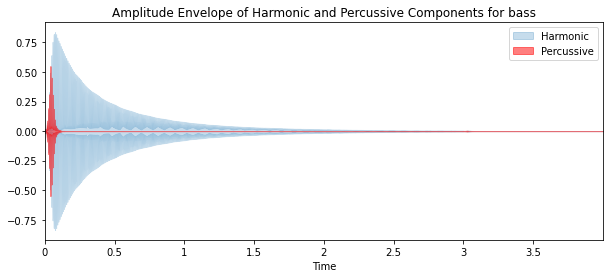

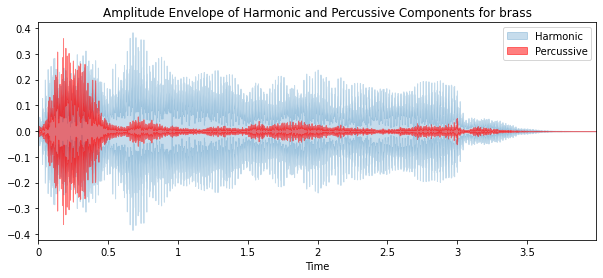

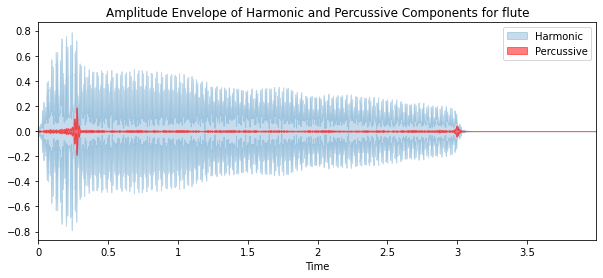

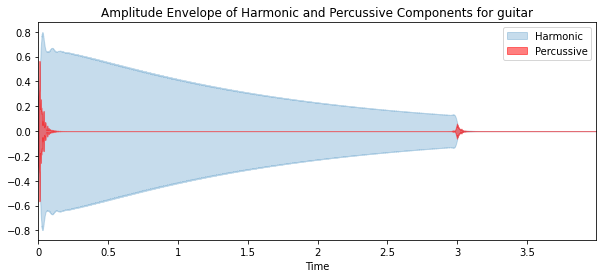

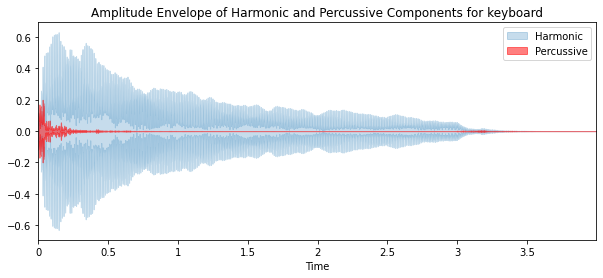

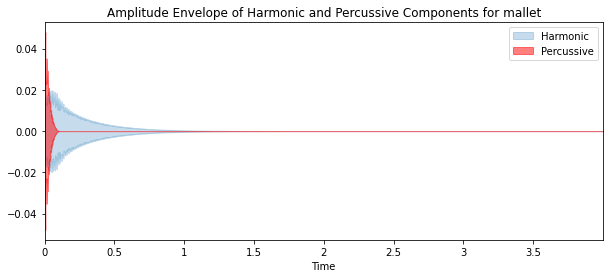

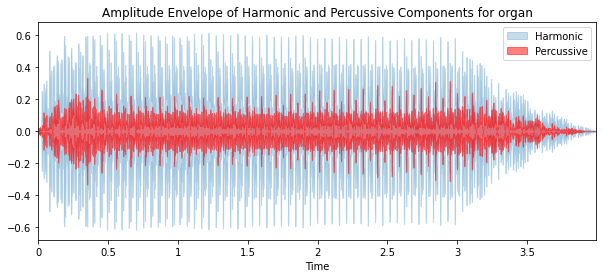

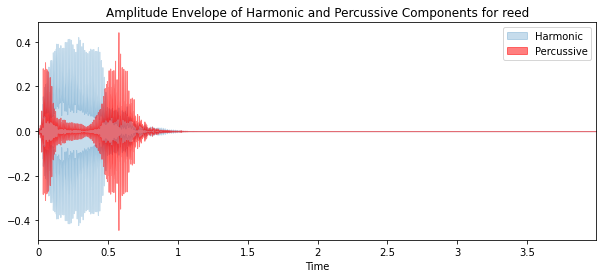

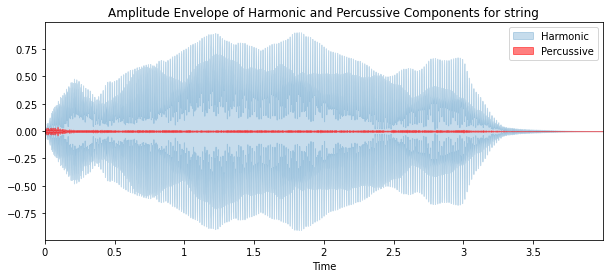

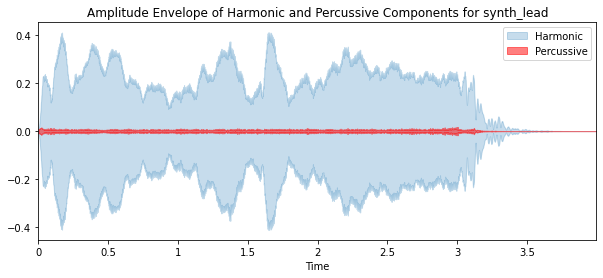

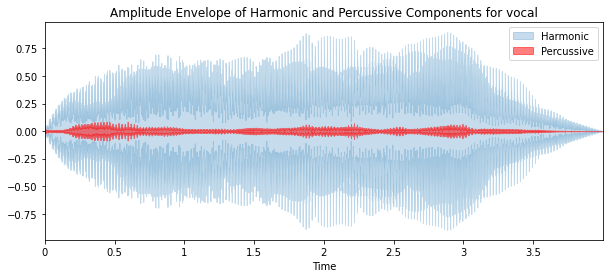

In [10]:
for i, j  in enumerate(y):
    plt.figure(figsize=(10,4))
    librosa.display.waveplot(y_harmonic[i], sr=sr[i], alpha=0.25)
    librosa.display.waveplot(y_percussive[i], sr=sr[i], color='r', alpha=0.5)
    plt.legend(['Harmonic', 'Percussive'])
    plt.title("Amplitude Envelope of Harmonic and Percussive Components for " + class_names[i])
    plt.savefig(plots_dir+'soundsAsArrays_'+str(class_names[i])+'.png')
    plt.show()

### Beat & Tempo: [librosa.beat.beat_track](https://librosa.github.io/librosa/generated/librosa.beat.beat_track.html)

The <b>tempo</b> is the rate of speed of a musical piece or passage indicated by one of a series of directions (such as largo, presto, or allegro) and often by an exact metronome marking.<br>
Source:<br>
[Merriam Webster](https://www.merriam-webster.com/dictionary/tempo)

In [11]:
for i, j in enumerate(y):
    try:
        tempo, beat_frames = librosa.beat.beat_track(y=y[i], sr=sr[i])
        print("In example ",i," the tempo is ", tempo, "and the beat frames are ", beat_frames)
    except:
        print("Not valid") 


In example  0  the tempo is  117.1875 and the beat frames are  [3]
In example  1  the tempo is  41.666666666666664 and the beat frames are  [4]
In example  2  the tempo is  117.1875 and the beat frames are  [3]
In example  3  the tempo is  117.1875 and the beat frames are  [79 95]
In example  4  the tempo is  0 and the beat frames are  []
In example  5  the tempo is  0 and the beat frames are  []
In example  6  the tempo is  117.1875 and the beat frames are  [12]
In example  7  the tempo is  62.5 and the beat frames are  [3]
In example  8  the tempo is  110.29411764705883 and the beat frames are  [4]
In example  9  the tempo is  125.0 and the beat frames are  [ 3 18]
In example  10  the tempo is  312.5 and the beat frames are  [4]


C:\Users\alver\anaconda3\envs\NSynth\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


Since we have a single note there's no such thing as a tempo.

### Chroma Energy: [librosa.feature.chroma_cens](https://librosa.github.io/librosa/generated/librosa.feature.chroma_cens.html)

Two pitches are perceived as similar in “color” if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma. Assuming the equal-tempered scale, the <b>chromas</b> correspond to the set {C, C♯, D, . . . , B} that consists of the twelve pitch spelling attributes as used in Western music notation. Thus, a chroma feature is represented by a 12 dimensional vector:<br>
x = (x(1), x(2), ..., x(12))T<br>
Where x(1) corresponds to chroma C, x(2) to chroma C# and so on. In the feature extraction step, a given audio signal is converted into a sequence of chroma features each expressing how the short-time energy of the signal is spread over the twelve chroma bands.<br>

Source:<br>
[Meinard Müller and Sebastian Ewert Chroma Toolbox: MATLAB implementations for extracting variants of chroma-based audio features In Proceedings of the International Conference on Music Information Retrieval (ISMIR), 2011.](http://ismir2011.ismir.net/papers/PS2-8.pdf)

In [12]:
chromas = []
for y_, sr_ in zip(y, sr):
    chromas.append(librosa.feature.chroma_cens(y=y_, sr=sr_))

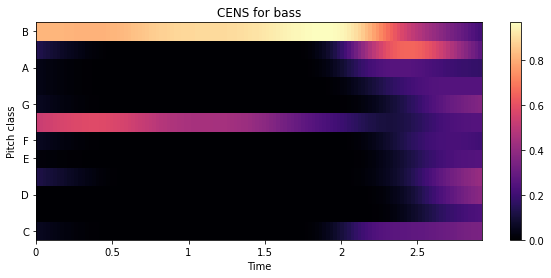

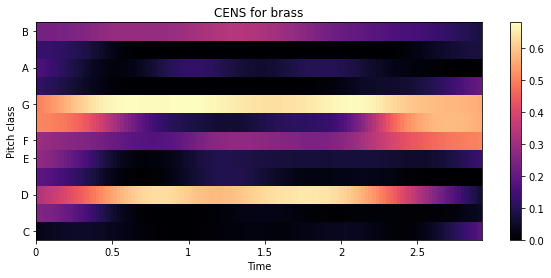

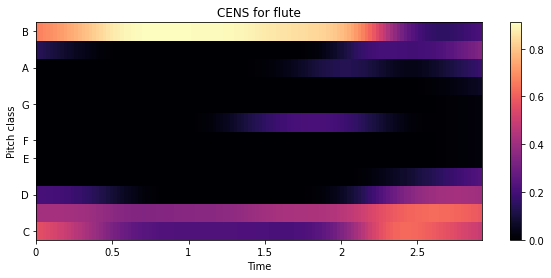

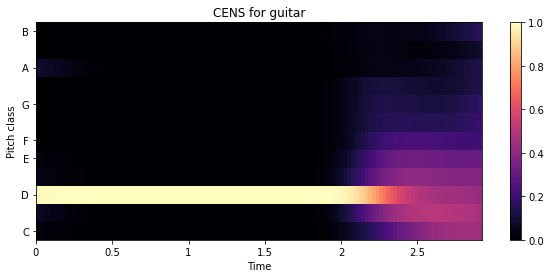

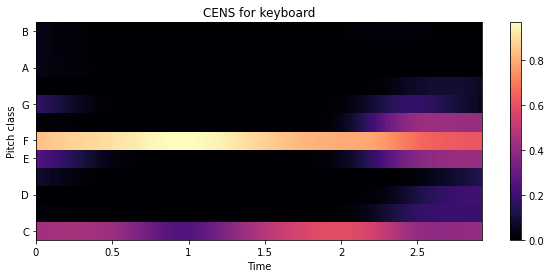

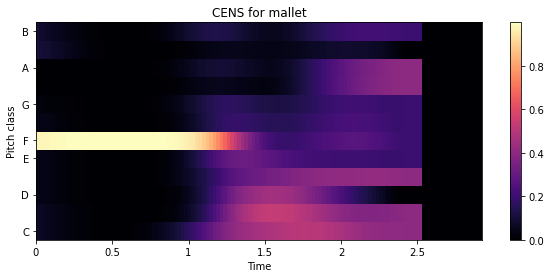

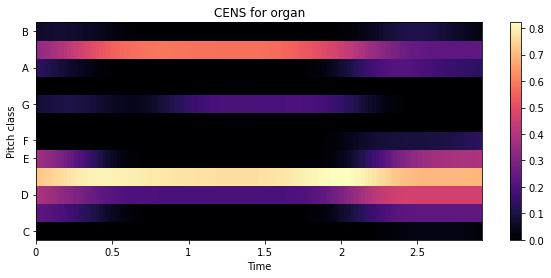

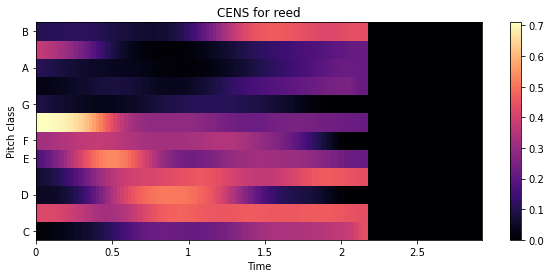

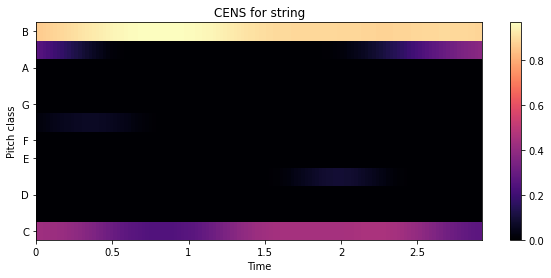

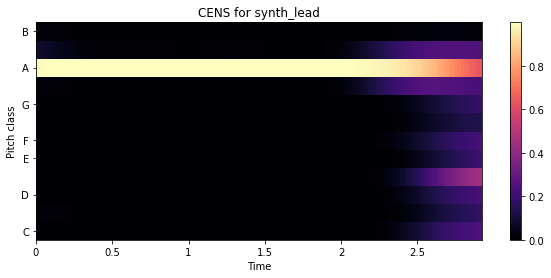

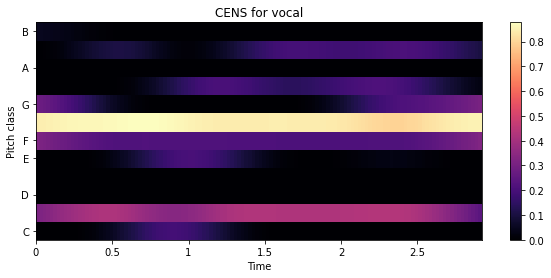

In [13]:
for chroma, instrument, i in zip(chromas,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title("CENS for " + instrument)
    plt.savefig(plots_dir+'ChromaEnergy_'+str(class_names[i])+'.png')
    plt.show()



### Mel Spectrogram [librosa.feature.melspectrogram](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html)

The <b>spectrogram</b> is a basic tool in audio spectral analysis and other fields. It has been applied extensively in speech analysis. The spectrogram can be defined as an intensity plot (usually on a log scale, such as dB) of the Short-Time Fourier Transform (STFT) magnitude. The STFT is simply a sequence of Fast Fourier Transforms (FFT) of windowed data segments, where the windows are usually allowed to overlap in time, typically by 25-50%. It is an important representation of audio data because human hearing is based on a kind of real-time spectrogram encoded by the cochlea of the inner ear. <br>The spectrogram has been used extensively in the field of computer music as a guide during the development of sound synthesis algorithms. When working with an appropriate synthesis model, matching the spectrogram often corresponds to matching the sound extremely well. In fact, spectral modeling synthesis (SMS) is based on synthesizing the short-time spectrum directly by some means.<br>

The <b>mel</b> is a unit of pitch. The mel scale is a scale of pitches judged by listeners to be equal in distance one from another.


Sources:<br>
[Spectrograms](https://ccrma.stanford.edu/~jos/st/Spectrograms.html)<br>
[Stevens, Stanley Smith; Volkmann; John & Newman, Edwin B. (1937). "A scale for the measurement of the psychological magnitude pitch"](https://archive.is/20130414065947/http://asadl.org/jasa/resource/1/jasman/v8/i3/p185_s1)

In [14]:
spectrograms_mel = []

for y_, sr_ in zip(y, sr):
    # Passing through arguments to the Mel filters
    spectrograms_mel.append(librosa.feature.melspectrogram(y=y_, sr=sr_, n_mels=128,fmax=8000))

C:\Users\alver\anaconda3\envs\NSynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\alver\anaconda3\envs\NSynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


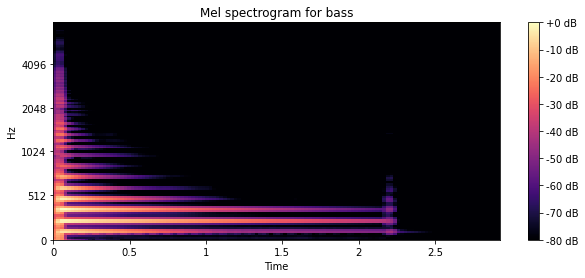

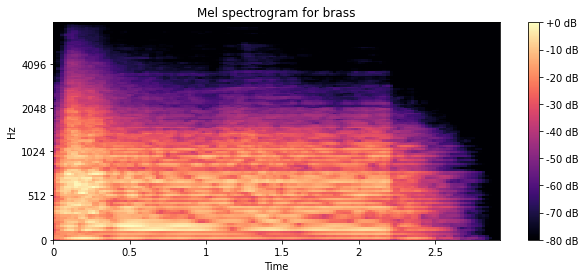

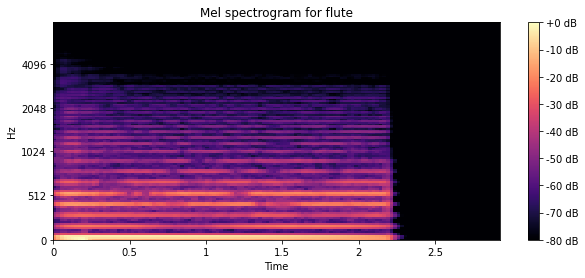

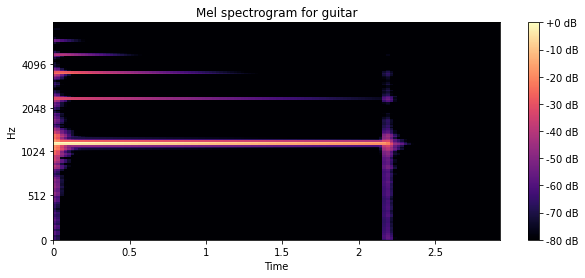

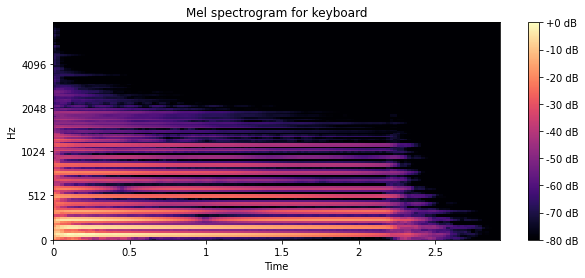

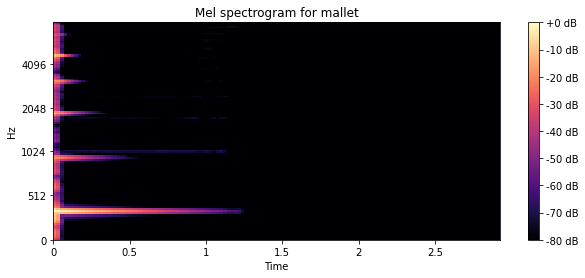

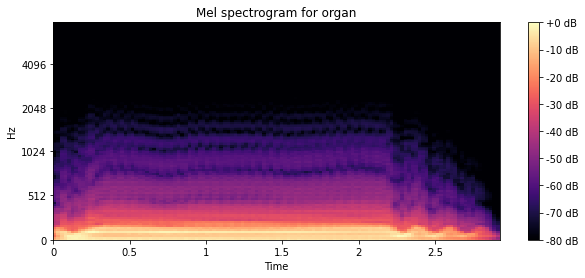

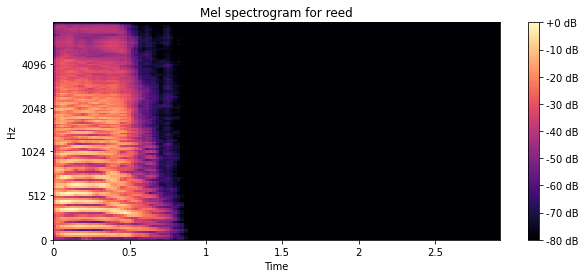

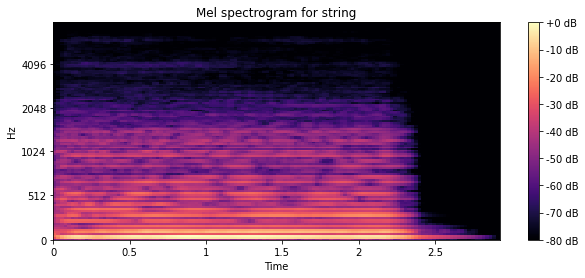

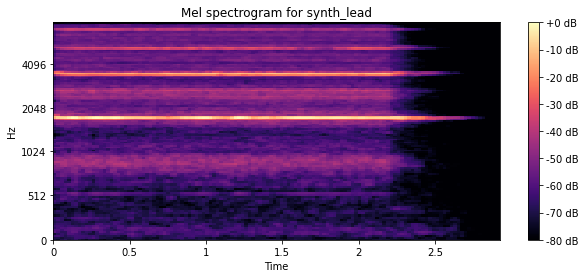

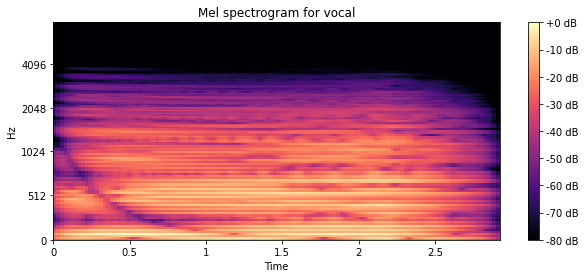

In [15]:
for S, instrument, i in zip(spectrograms_mel,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel spectrogram for " + instrument)
    plt.savefig(plots_dir+'mel_spectro_'+str(class_names[i])+'.png')
    plt.show()

C:\Users\alver\anaconda3\envs\NSynth\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


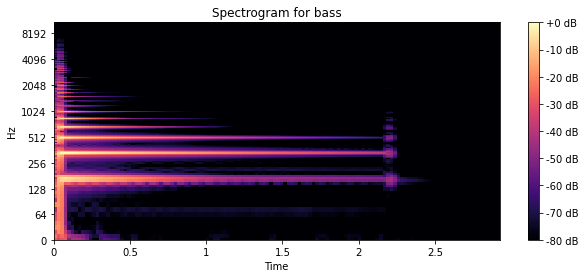

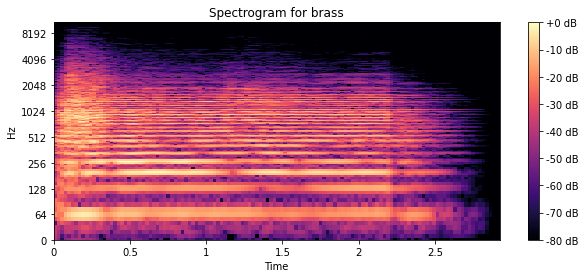

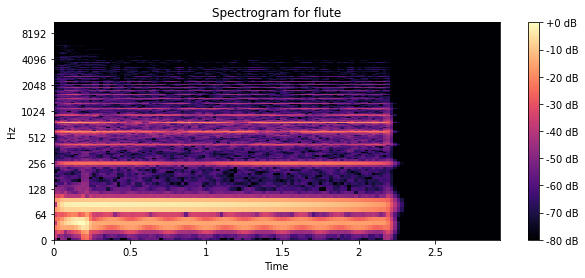

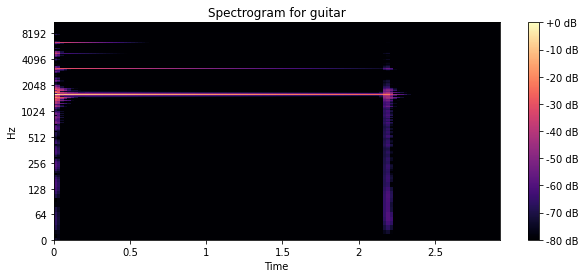

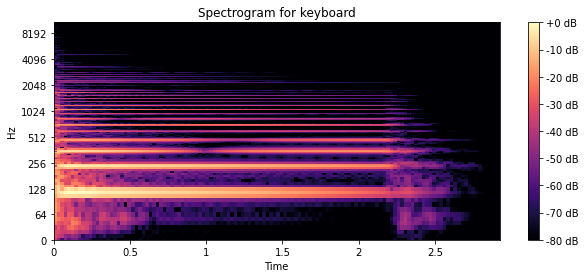

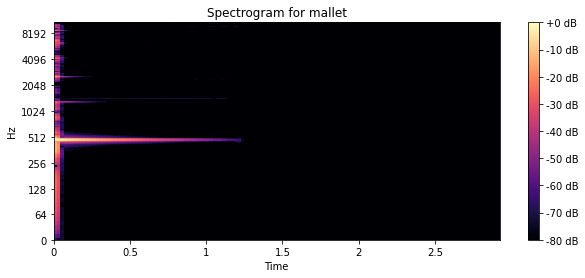

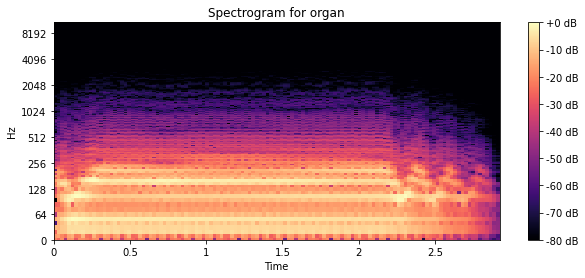

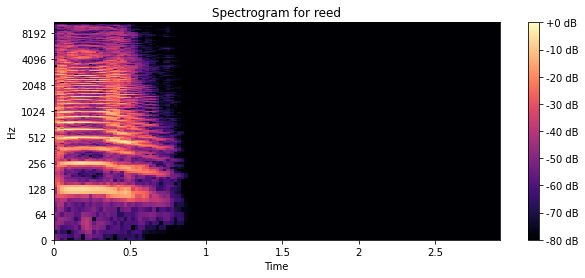

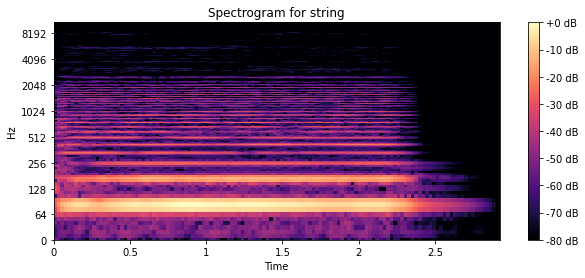

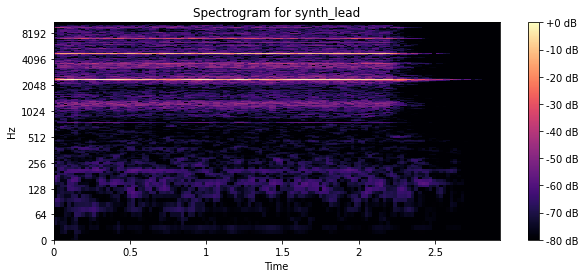

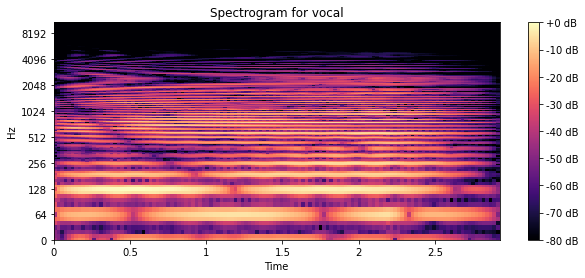

In [16]:
spectrograms = []

for y_, sr_ in zip(y, sr):
    # Use left-aligned frames, instead of centered frames
    D = np.abs(librosa.stft(y_))
    spectro = librosa.amplitude_to_db(D, ref=np.max)
    spectrograms.append(spectro)

for S, instrument, i in zip(spectrograms,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S, 
                         y_axis='log', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram for " + instrument)
    plt.savefig(plots_dir+'spectro_'+str(class_names[i])+'.png')
    plt.show()

### Mel-Frequency Cepstral Coefficients: [librosa.feature.mfcc](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)

The <b>mel-frequency cepstrum (MFC)</b> is a presentation of the short term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. MFC coefficients are the coefficients that make up an MFC. Using a mel scale means that the bands are equally scaled, which resembles the human hearing system more than linearly spaced based bands in a normal spectrum.<br>

MFCCs are commonly derived as follows:<br>

1) Take the Fourier transform of (a windowed excerpt of) a signal.<br>
2) Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.<br>
3) Take the logs of the powers at each of the mel frequencies.<br>
4) Take the discrete cosine transform of the list of mel log powers, as if it were a signal.<br>
5) The MFCCs are the amplitudes of the resulting spectrum.<br>

Sources:<br>
[Speech Processing for Machine Learning](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)<br>
[Wikipedia: Mel Frequency Cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)<br>
[Mel Frequency Cepstral Coefficient (MFCC) tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/#why-do-we-do-these-things)

In [17]:
mfccs = []
for y_, sr_ in zip(y, sr):
    mfccs.append(librosa.feature.mfcc(y=y_, sr=sr_, n_mfcc=13))

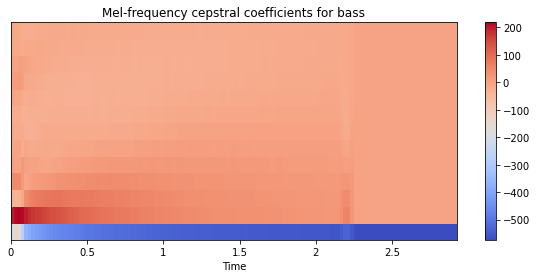

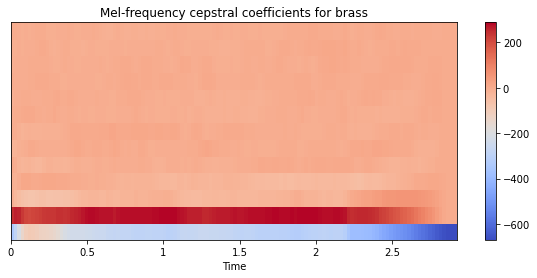

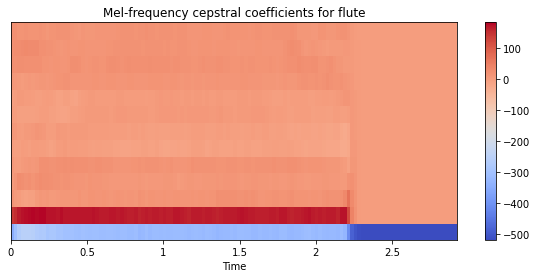

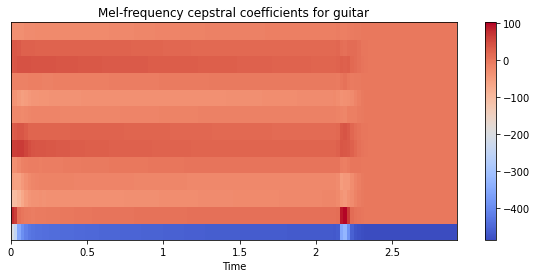

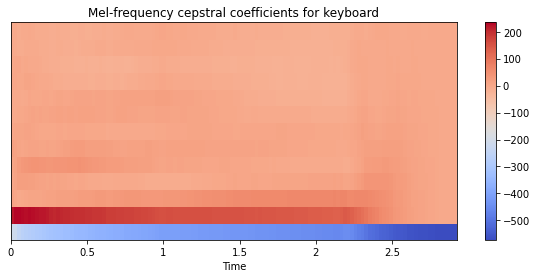

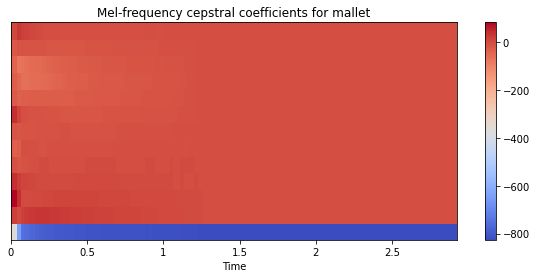

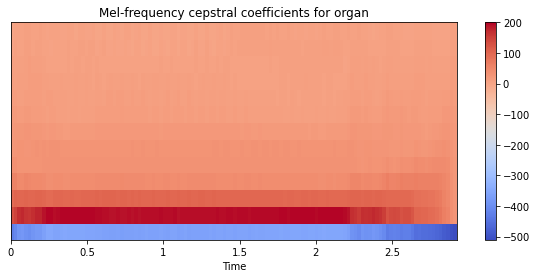

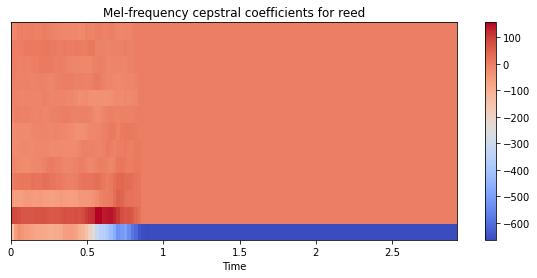

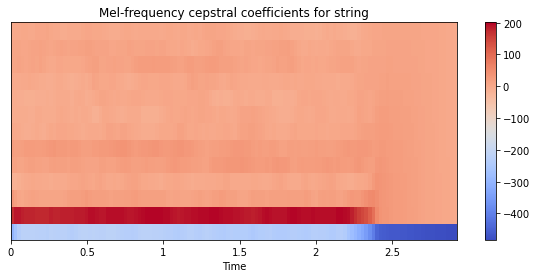

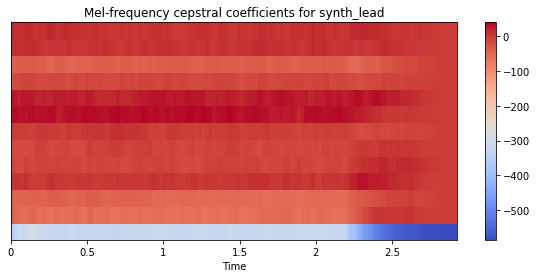

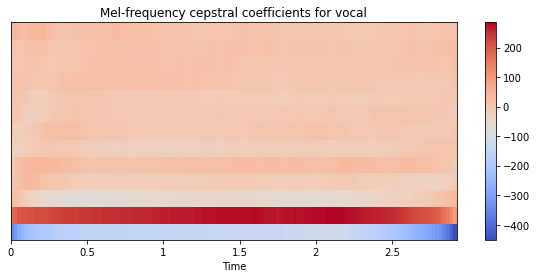

In [18]:
for mfcc, instrument,i in zip(mfccs,class_names,range(len(class_names))):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('Mel-frequency cepstral coefficients for ' + instrument)
    plt.savefig(plots_dir+'mfcc'+str(class_names[i])+'.png')
    plt.show()

### Spectral Centroid: [librosa.feature.spectral_centroid](https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html)

The <b>spectral centroid</b> is commonly associated with the measure of the brightness of a sound. This measure is obtained by evaluating the “center of gravity” using the Fourier transform’s frequency and magnitude information. The individual centroid of a spectral frame is defined as the average frequency weighted by amplitudes, divided by the sum of the amplitudes.<br>

Source:<br>
[Spectral Centroid](https://www.cs.cmu.edu/~music/icm/slides/05-algorithmic-composition.pdf)

In [19]:
centroids = []
spectrograms = []
phases = []

for y_, sr_ in zip(y, sr):
    centroids.append(librosa.feature.spectral_centroid(y=y_, sr=sr_))
    spectrograms.append(librosa.magphase(librosa.stft(y=y_))[0])
    phases.append(librosa.magphase(librosa.stft(y=y_))[1])

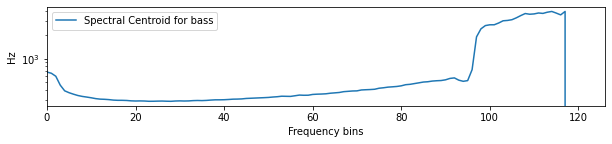

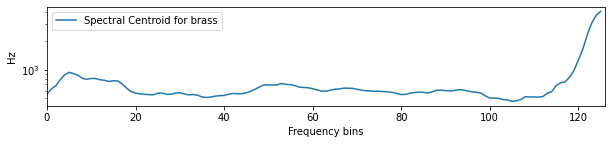

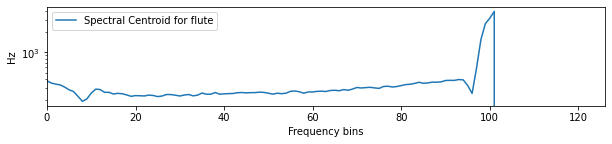

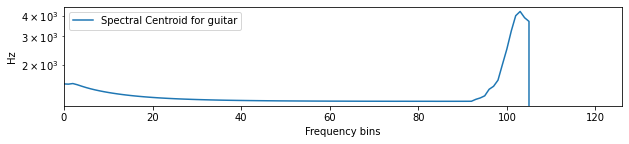

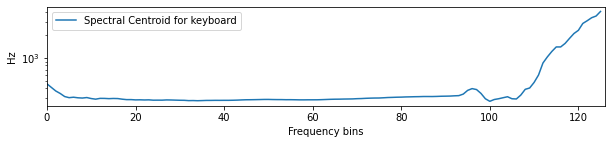

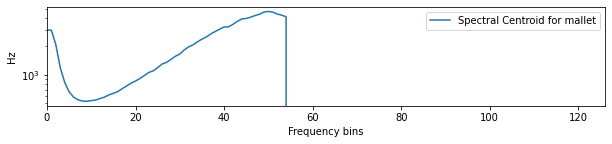

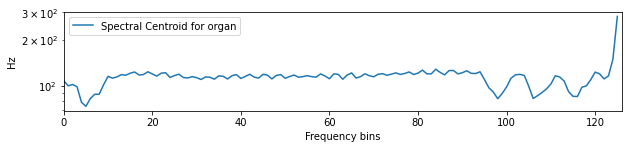

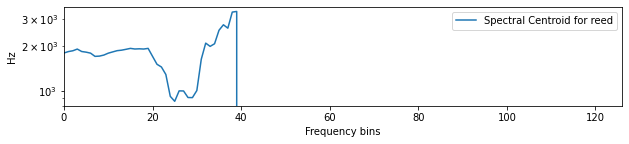

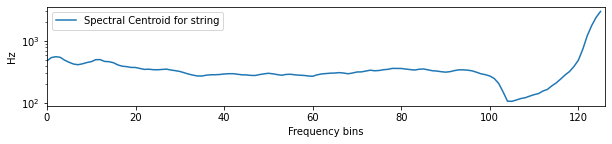

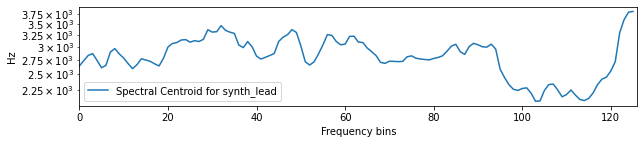

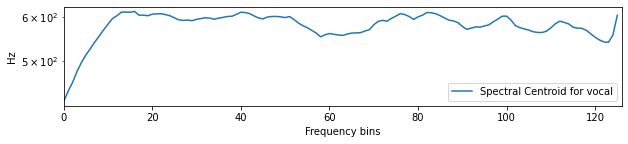

In [20]:
#Make a plot with log scaling on the y axis.
for C, instrument, S, i in zip(centroids ,class_names, spectrograms, range(len(class_names))):
    plt.figure(figsize=(10,4))
    plt.subplot(2, 1, 1)
    plt.semilogy(C.T, label='Spectral Centroid for ' + instrument)
    plt.ylabel('Hz')
    plt.xticks(np.arange(0,C.shape[-1],20))
    plt.xlim([0, C.shape[-1]])
    plt.xlabel('Frequency bins')
    plt.legend()
    plt.savefig(plots_dir+'spectral_centroid'+str(class_names[i])+'.png')
    plt.show()

### Spectral Contrast: [librosa.feature.spectral_contrast](https://librosa.github.io/librosa/generated/librosa.feature.spectral_contrast.html)

<b>Spectral contrast</b> is defined as the level difference between peaks and valleys in the spectrum. Octave-based Spectral Contrast considers the spectral peak, spectral valley and their difference in each sub-band.<br>
Source: <br>
[Jiang, Dan-Ning, Lie Lu, Hong-Jiang Zhang, Jian-Hua Tao, and Lian-Hong Cai. “Music type classification by spectral contrast feature.” In Multimedia and Expo, 2002. ICME‘02. Proceedings. 2002 IEEE International Conference on, vol. 1, pp. 113-116. IEEE, 2002.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.583.7201&rep=rep1&type=pdf)

In [21]:
contrasts = []
for y_, sr_ in zip(y, sr):
    contrasts.append(librosa.feature.spectral_contrast(y=y_, sr=sr_))

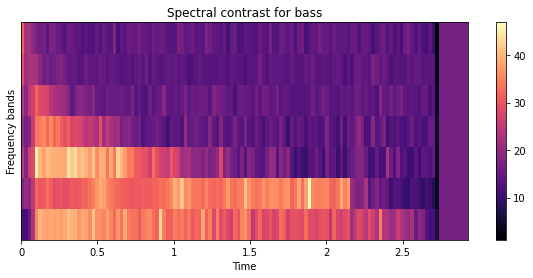

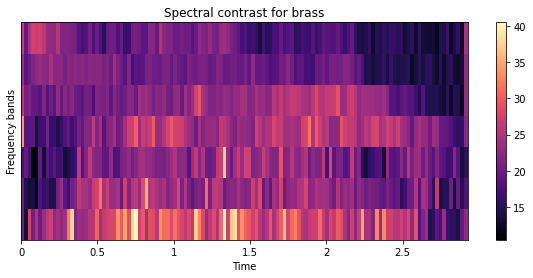

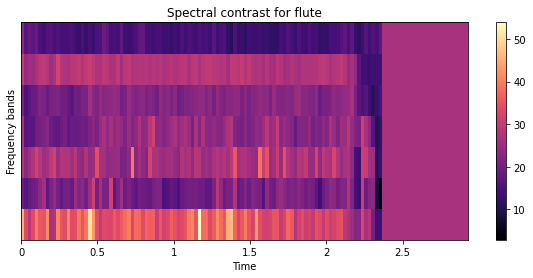

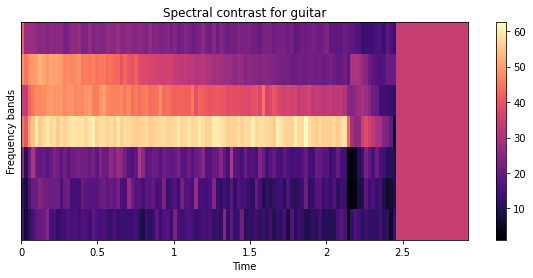

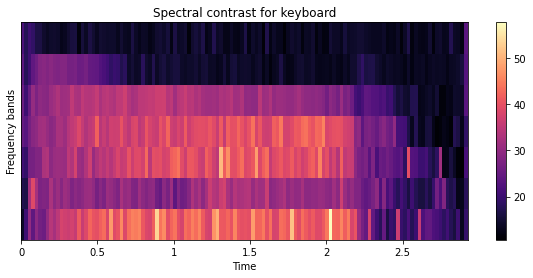

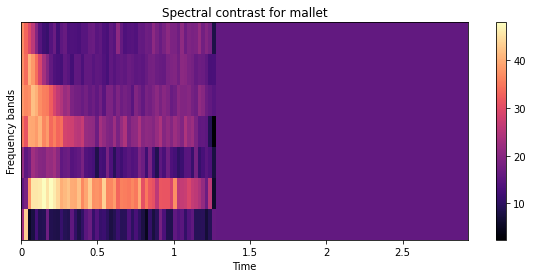

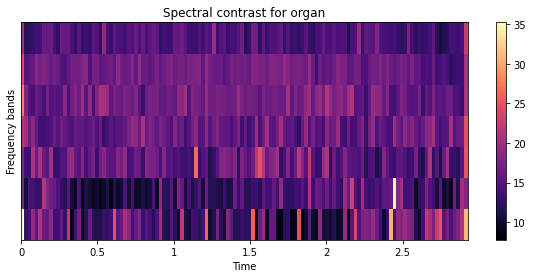

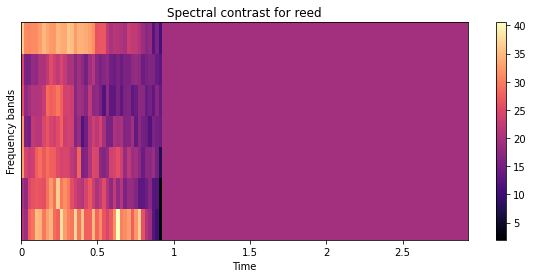

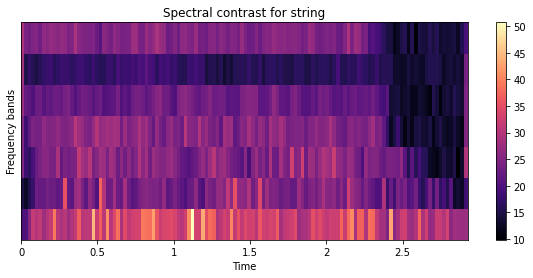

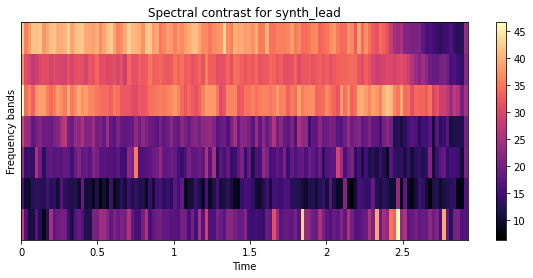

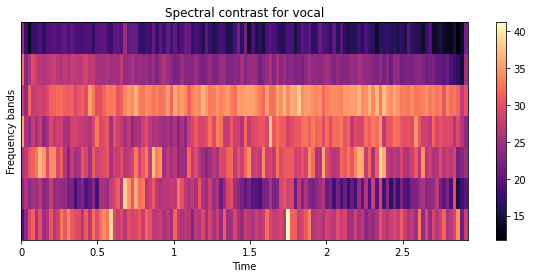

In [22]:
for contrast, instrument, i in zip(contrasts,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(contrast,x_axis='time')
    plt.colorbar()
    plt.ylabel('Frequency bands')
    plt.title('Spectral contrast for '+ instrument)
    plt.savefig(plots_dir+'spectral_contrast_'+str(class_names[i])+'.png')
    plt.show()

### Spectral Rolloff Frequency: [librosa.feature.spectral_rolloff](https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html)

From the function docstring:<br>
The <b>roll-off frequency</b> is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

In [23]:
rolloffs = []
for y_, sr_ in zip(y, sr):
    rolloffs.append(librosa.feature.spectral_rolloff(y=y_, sr=sr_))
    

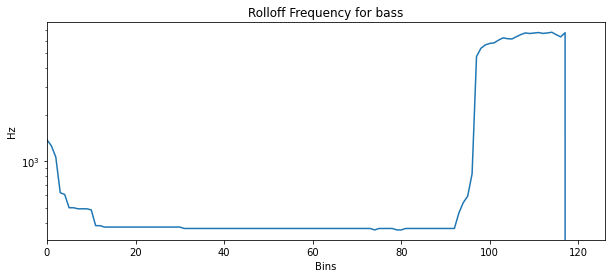

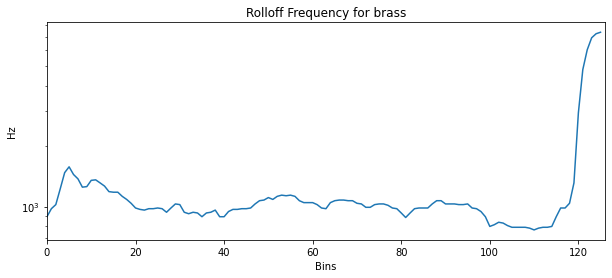

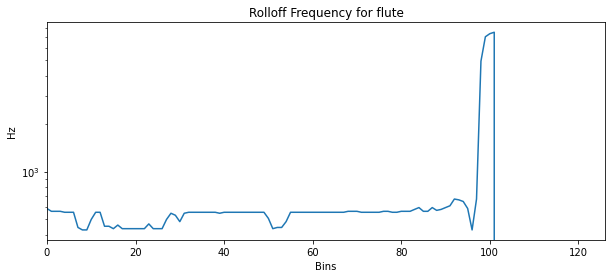

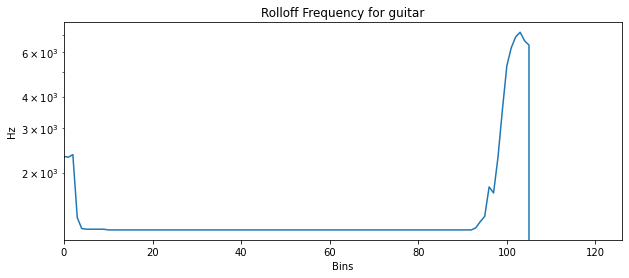

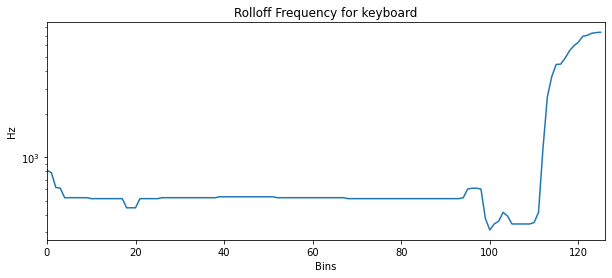

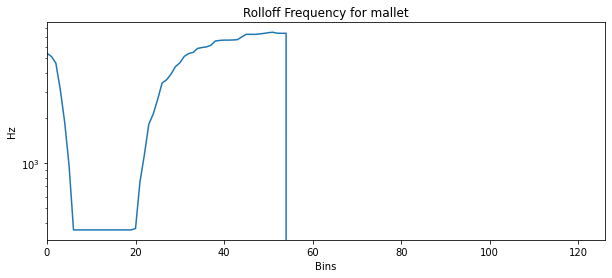

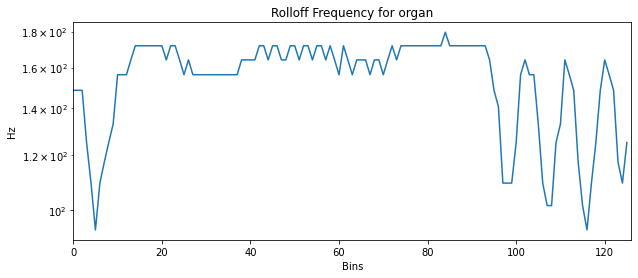

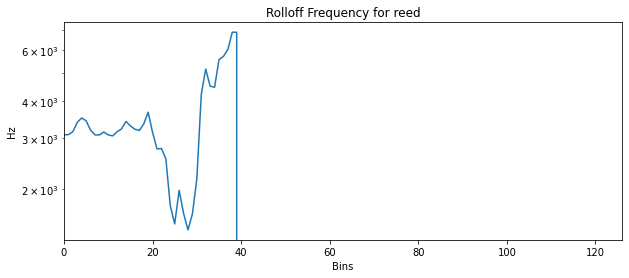

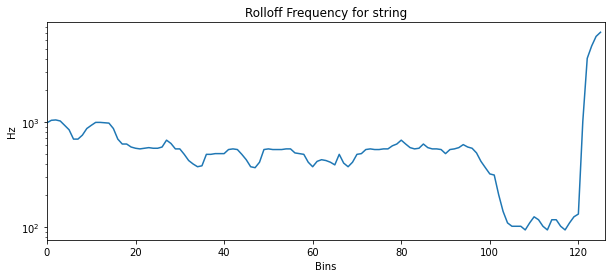

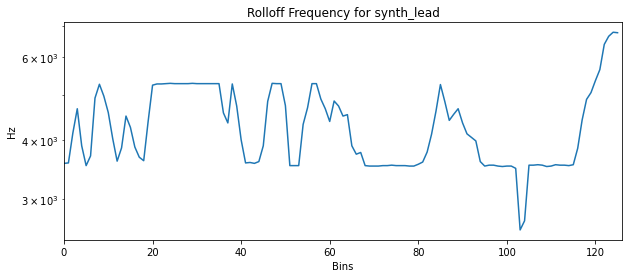

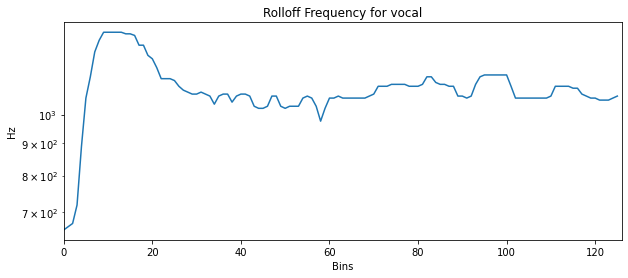

In [24]:
for rolloff, instrument, i in zip(rolloffs,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    plt.semilogy(rolloff.T, label='Rolloff frequency for ' + instrument)
    plt.ylabel('Hz')
    plt.xlim([0, rolloff.shape[-1]])
    plt.xlabel('Bins')
    plt.xticks(np.arange(0,rolloff.shape[-1],20))
    plt.title("Rolloff Frequency for "+ class_names[i])
    plt.savefig(plots_dir+'rolloff_freq'+str(class_names[i])+'.png')
    plt.show()

### Zero Crossings: [librosa.core.zero_crossings](https://librosa.github.io/librosa/generated/librosa.core.zero_crossings.html)

Find the zero-crossings of a signal y

In [25]:
z_crossings = []
for y_ in y:
    z = librosa.zero_crossings(y_)
    #Find number of zero crossings
    z_crossings.append(np.sum(z))

### Zero Crossing Rate: [librosa.feature.zero_crossing_rate](https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html)

Compute the zero-crossing rate of an audio time series.

In [26]:
zrates = []
for y_ in y:
    zrates.append(librosa.feature.zero_crossing_rate(y=y_))

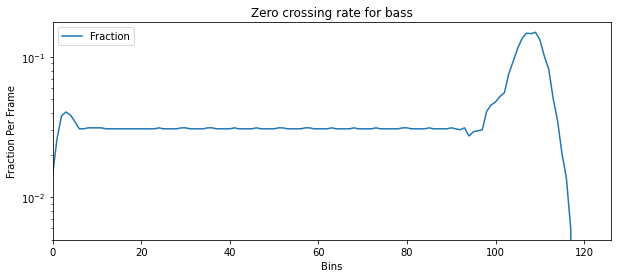

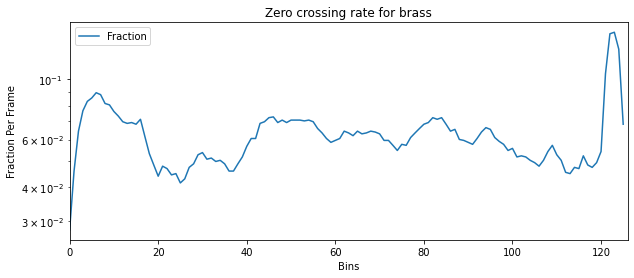

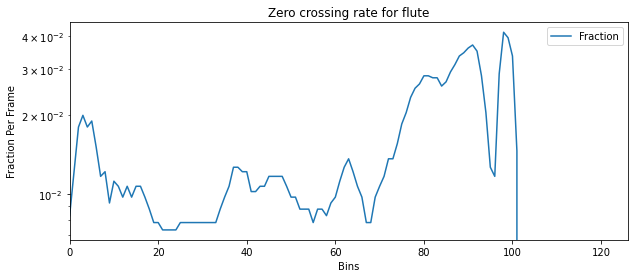

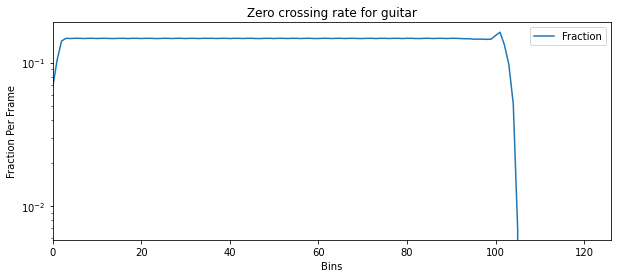

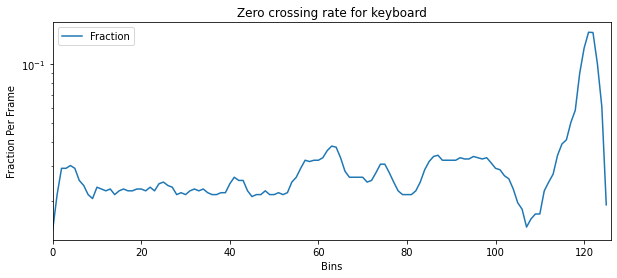

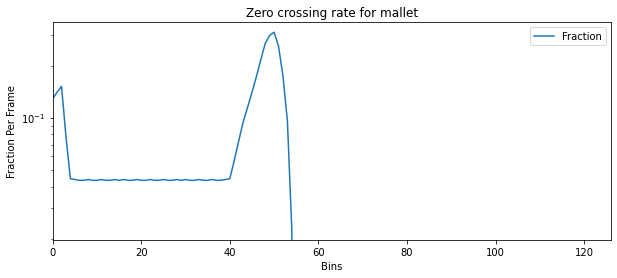

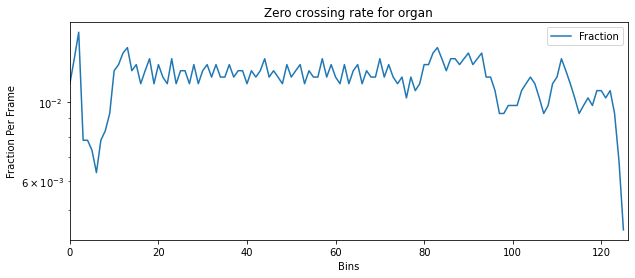

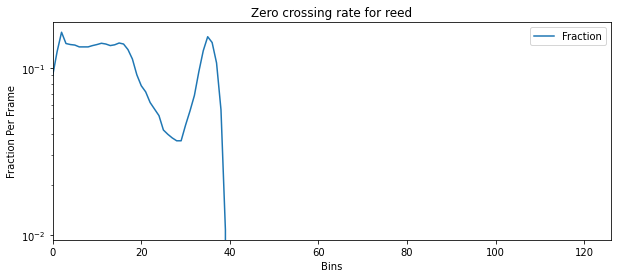

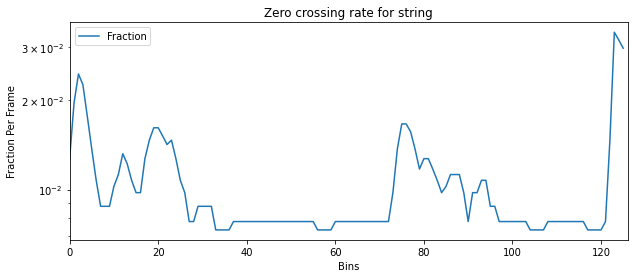

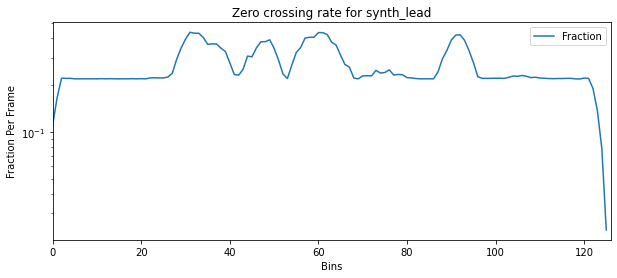

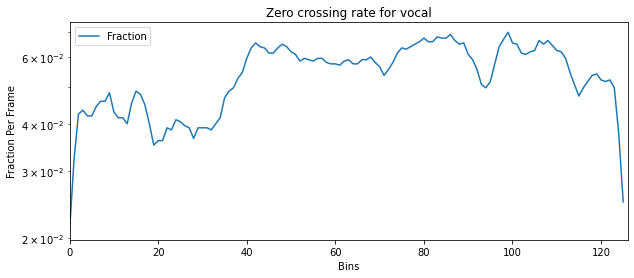

In [27]:
for zrate, instrument, i in zip(zrates,class_names, range(len(class_names))):
    plt.figure(figsize=(10,4))
    plt.semilogy(zrate.T, label='Fraction')
    plt.ylabel('Fraction Per Frame')
    plt.xlabel('Bins')
    plt.xticks(np.arange(0, rolloff.shape[-1], 20))
    plt.xlim([0, rolloff.shape[-1]])
    plt.title("Zero crossing rate for "+ instrument)
    plt.legend()
    plt.savefig(plots_dir+'zerocross_'+str(class_names[i])+'.png')
    plt.show()

In [28]:
zrate.shape

(1, 126)

# Linear Predictive Coding (LPC): librosa.lpc

"This function applies Burg’s method to estimate coefficients of a linear filter on y of order order. Burg’s method is an extension to the Yule-Walker approach, which are both sometimes referred to as LPC parameter estimation by autocorrelation.

It follows the description and implementation approach described in the introduction by Marple. 1 N.B. This paper describes a different method, which is not implemented here, but has been chosen for its clear explanation of Burg’s technique in its introduction."
Source:
- Larry Marple. A New Autoregressive Spectrum Analysis Algorithm. IEEE Transactions on Accoustics, Speech, and Signal Processing vol 28, no. 4, 1980.
- https://librosa.org/doc/main/generated/librosa.lpc.html

In [50]:
lpcs = []
for y_, sr_ in zip(y, sr):
    lpcs.append(librosa.lpc(y_, 2)) 

## Feature Summary

### Normalize Chroma Energy

In [30]:
chroma_means = []
chroma_stds = []

for chroma in chromas:
    chroma_means.append(np.mean(chroma, axis=1))
    chroma_stds.append(np.std(chroma, axis=1))

[Background on octaves and equal temperament scale](https://en.wikipedia.org/wiki/Equal_temperament)

In [31]:
#Define octaves
octave=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

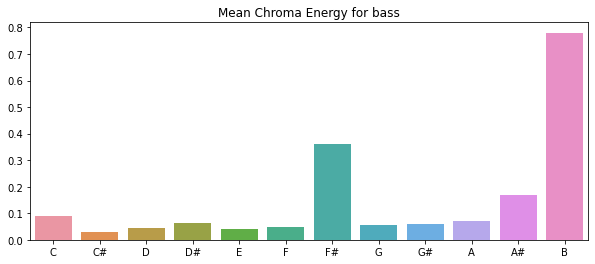

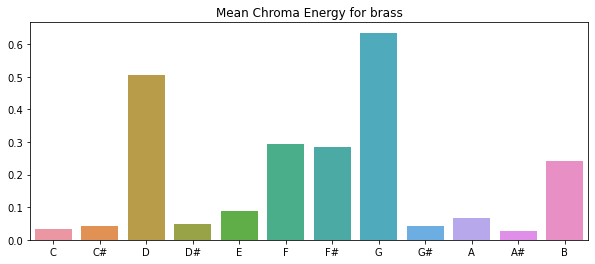

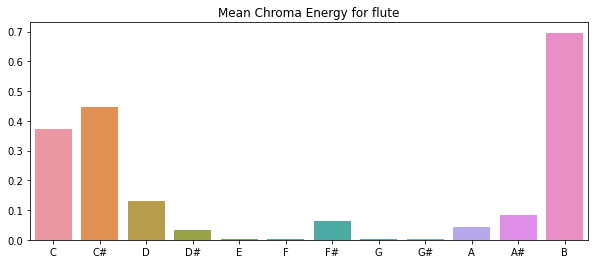

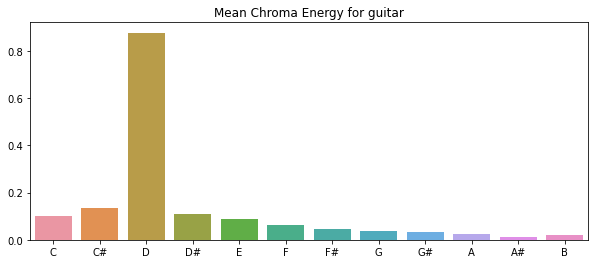

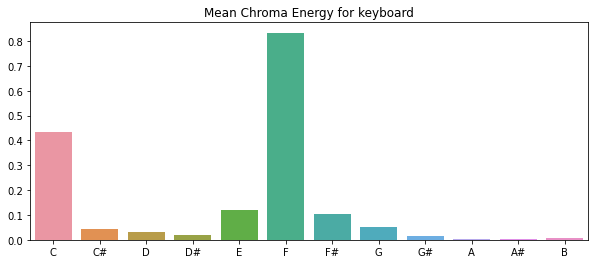

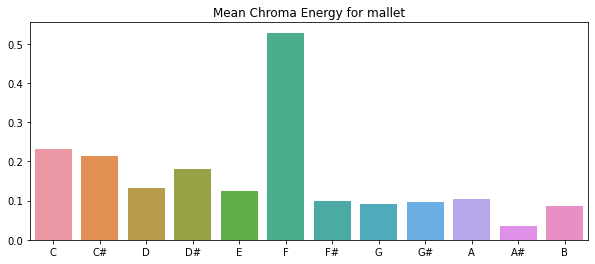

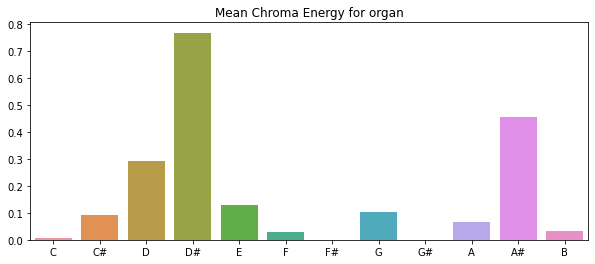

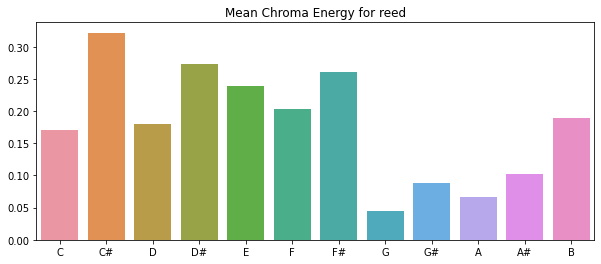

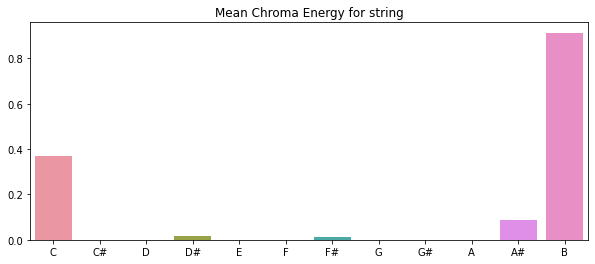

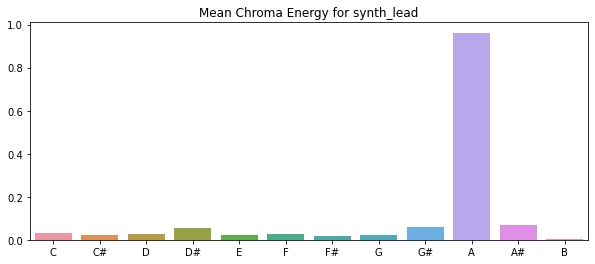

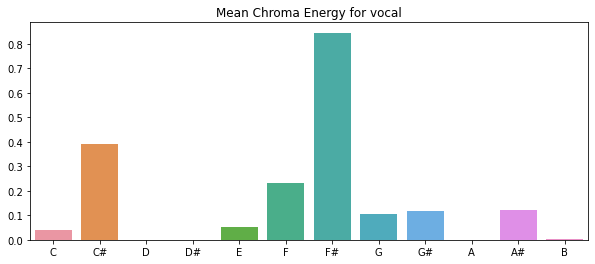

In [32]:
for chroma_mean,  instrument in zip(chroma_means,class_names):
    plt.figure(figsize=(10,4))
    plt.title("Mean Chroma Energy for "+ instrument)
    sns.barplot(x=octave, y=chroma_mean)

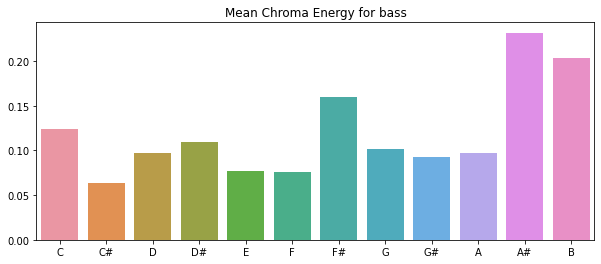

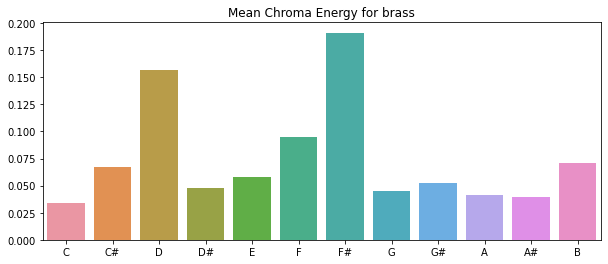

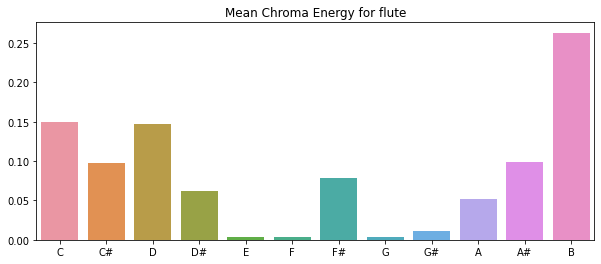

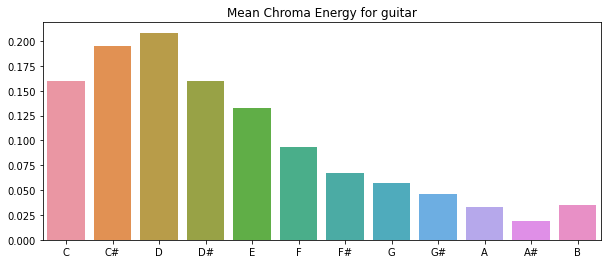

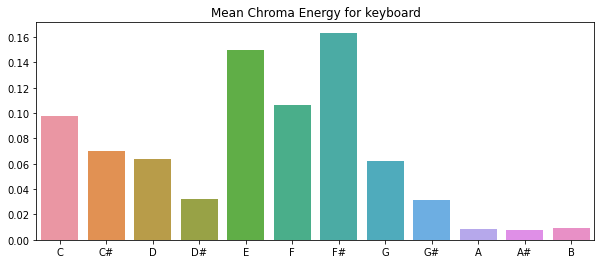

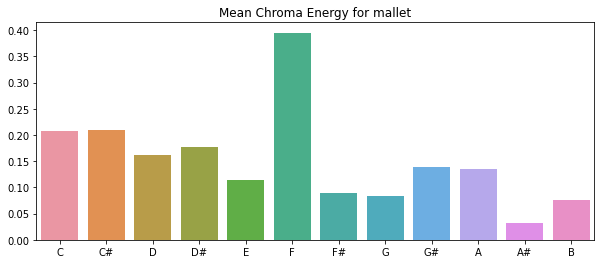

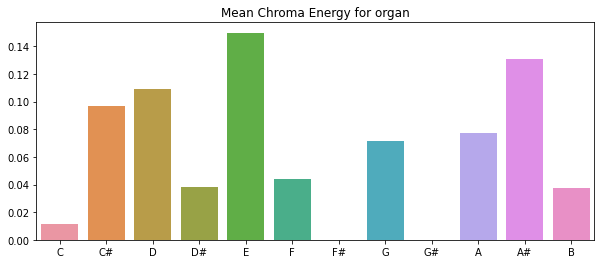

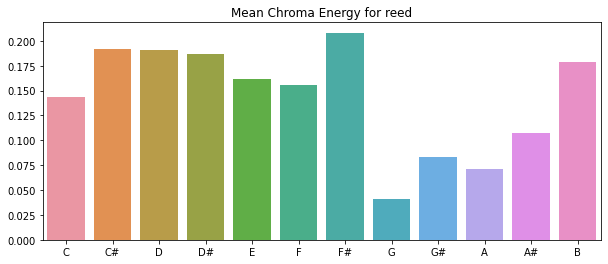

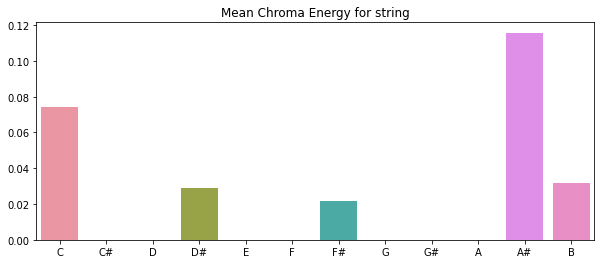

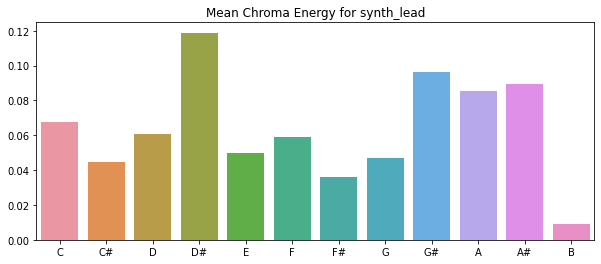

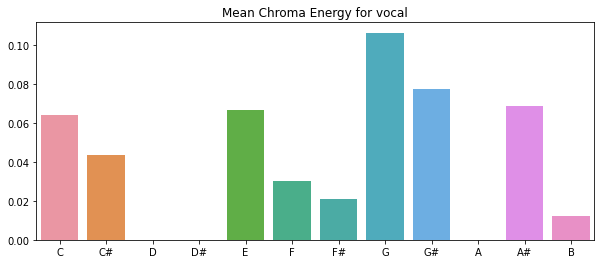

In [33]:
for chroma_std, instrument in zip(chroma_stds,class_names):
    plt.figure(figsize=(10,4))
    plt.title("Mean Chroma Energy for "+ instrument)
    sns.barplot(x=octave, y=chroma_std)

### Normalize Mel-Frequency Cepstral Coefficients 

In [34]:
mfcc_means = []
mfcc_stds = []
coefficients = []

for mfcc in mfccs:
    mfcc_means.append(np.mean(mfcc,axis=1))
    mfcc_stds.append(np.std(mfcc,axis=1))
    coefficients.append(np.arange(0,mfcc.shape[0]))

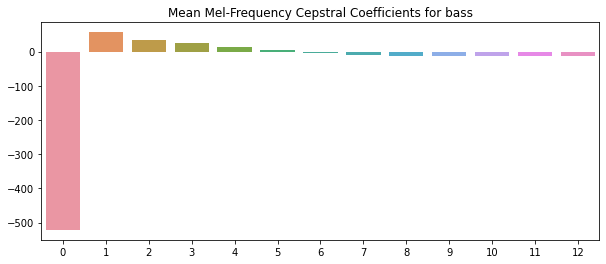

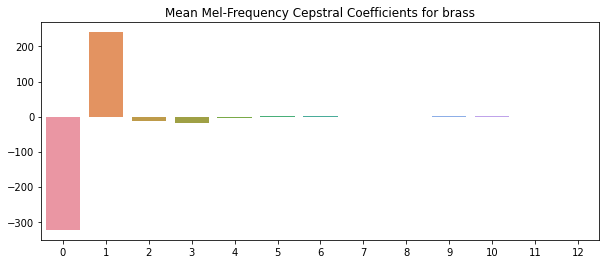

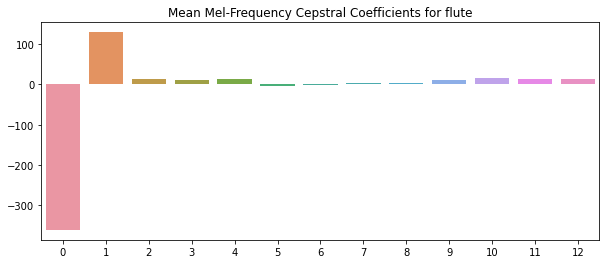

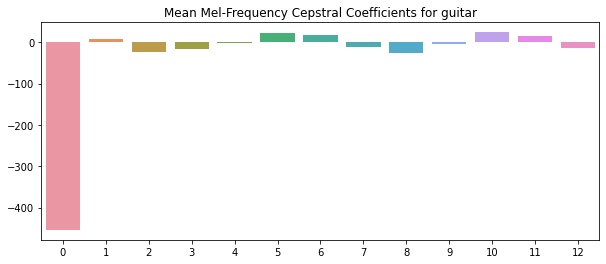

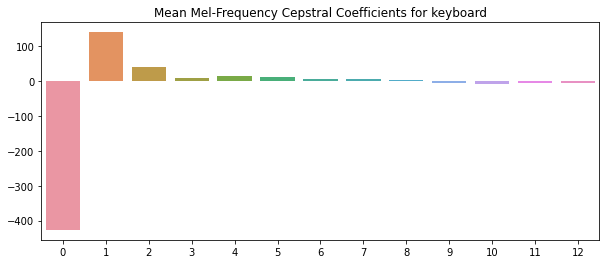

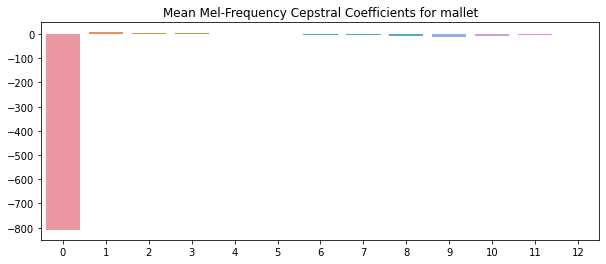

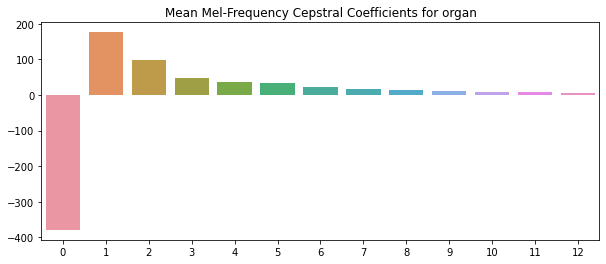

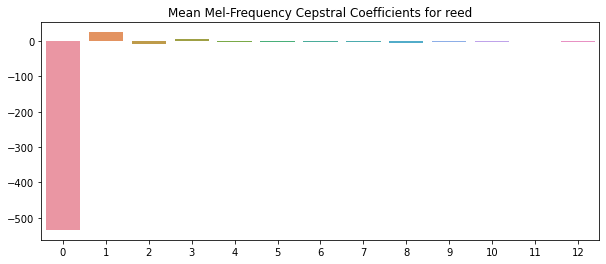

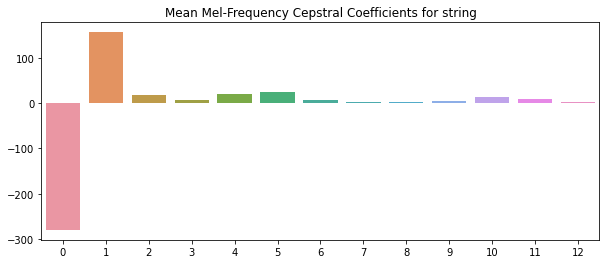

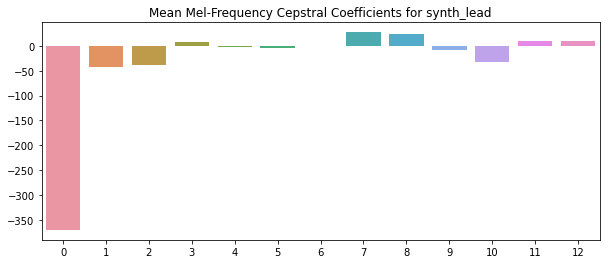

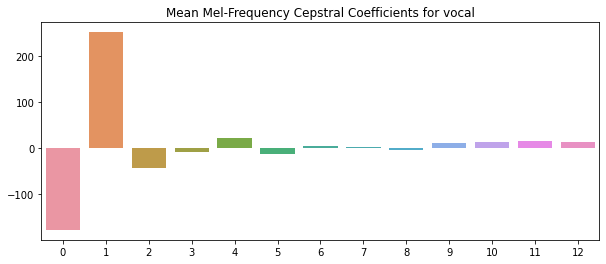

In [35]:
for mfcc_mean, coefficient, instrument in zip(mfcc_means, coefficients,class_names):
    plt.figure(figsize=(10,4))
    plt.title("Mean Mel-Frequency Cepstral Coefficients for " + instrument)
    sns.barplot(x=coefficient, y=mfcc_mean)

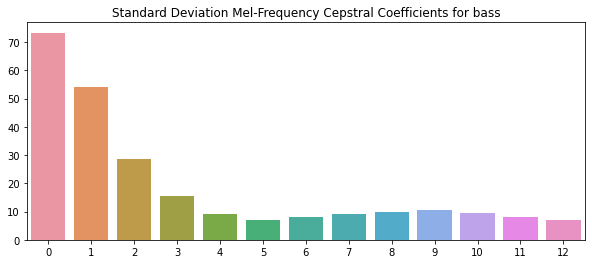

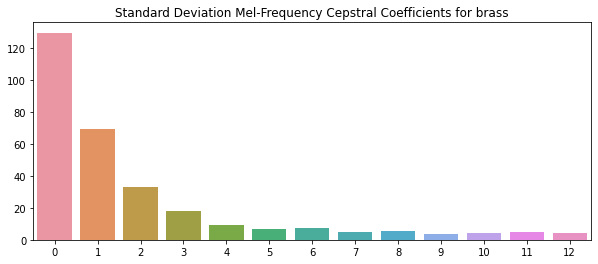

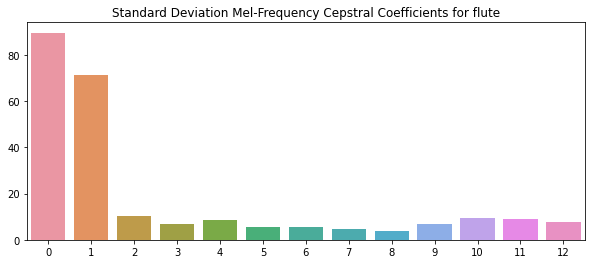

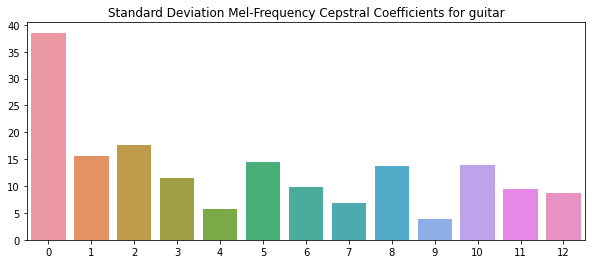

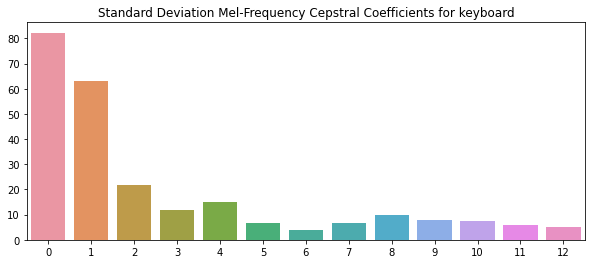

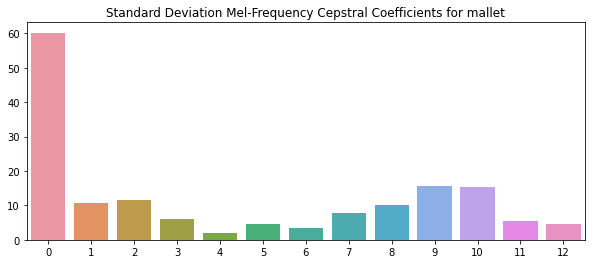

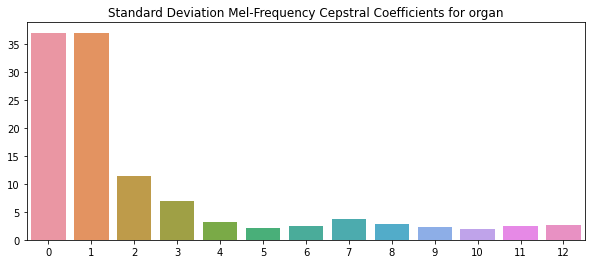

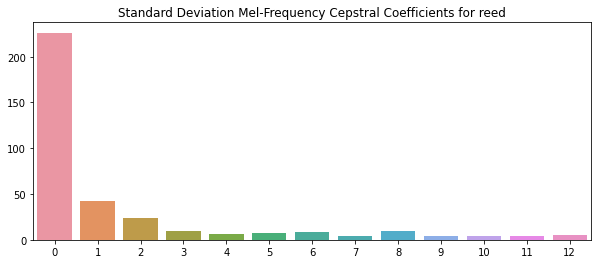

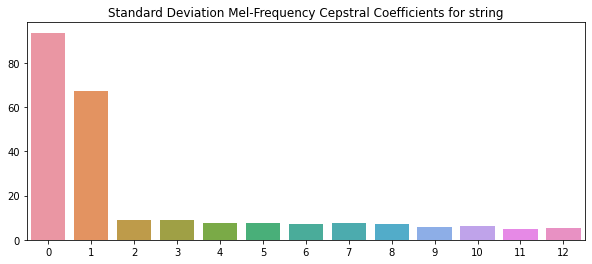

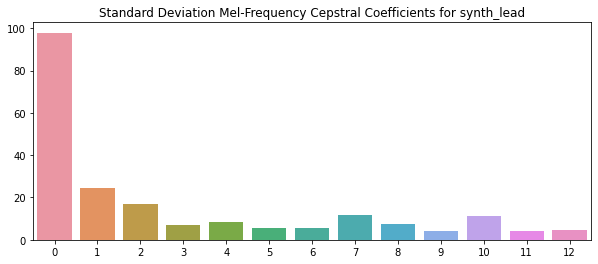

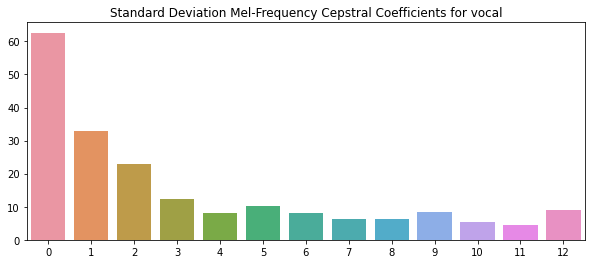

In [36]:
for mfcc_std, coefficient, instrument in zip(mfcc_stds, coefficients,class_names):
    plt.figure(figsize=(10,4))
    plt.title("Standard Deviation Mel-Frequency Cepstral Coefficients for " + instrument)
    sns.barplot(x=coefficient, y=mfcc_std)

### Spectral Centroid Summary

In [38]:
centroid_means = []
centroid_stds = []
centroid_skews = []

for i in range(len(centroids)):
    centroid_means.append(np.mean(centroids[i]))
    centroid_stds.append(np.std(centroids[i]))
    centroid_skews.append(scipy.stats.skew(centroids[i], axis=1)[0])
    print("Centroid mean of {} is {}".format(class_names[i], centroid_means[i]))
    print("Centroid standard deviation of {} is ".format(class_names[i], centroid_stds[i]))
    print("Centroid skewness of {} is {} \n".format(class_names[i], centroid_skews[i]))

Centroid mean of bass is 835.254892281172
Centroid standard deviation of bass is 
Centroid skewness of bass is 1.8919659577280874 

Centroid mean of brass is 718.5206674628693
Centroid standard deviation of brass is 
Centroid skewness of brass is 5.139236864581702 

Centroid mean of flute is 309.8748183092586
Centroid standard deviation of flute is 
Centroid skewness of flute is 5.5639584955102155 

Centroid mean of guitar is 1170.3580786207074
Centroid standard deviation of guitar is 
Centroid skewness of guitar is 1.4317867227820538 

Centroid mean of keyboard is 514.9016951134535
Centroid standard deviation of keyboard is 
Centroid skewness of keyboard is 3.5484437592966938 

Centroid mean of mallet is 914.3118471641919
Centroid standard deviation of mallet is 
Centroid skewness of mallet is 1.4469288211237867 

Centroid mean of organ is 113.58173913642807
Centroid standard deviation of organ is 
Centroid skewness of organ is 5.055902185480764 

Centroid mean of reed is 567.30225287

### Spectral Contrast Summary

In [37]:
contrast_means= []
contrast_stds= []
for C in contrasts:
    contrast_means.append(np.mean(C, axis=1))
    contrast_stds.append(np.mean(C, axis=1))

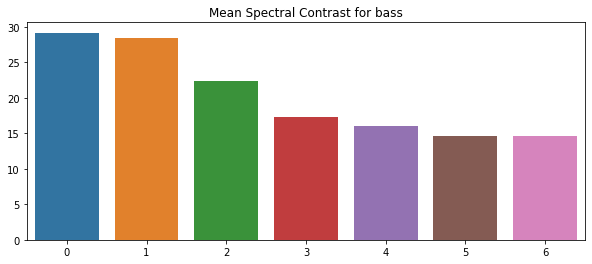

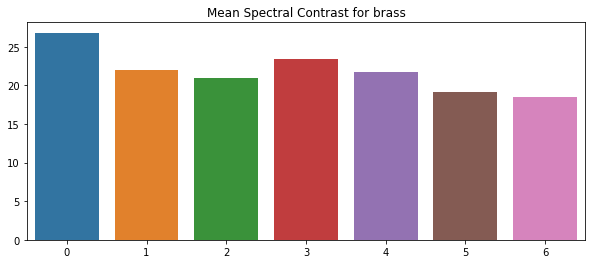

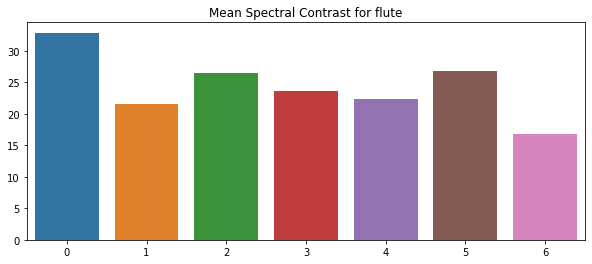

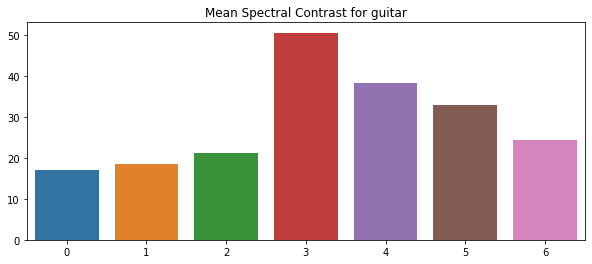

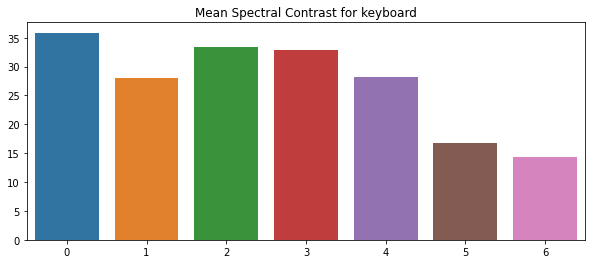

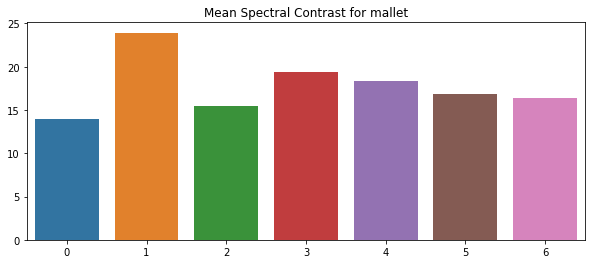

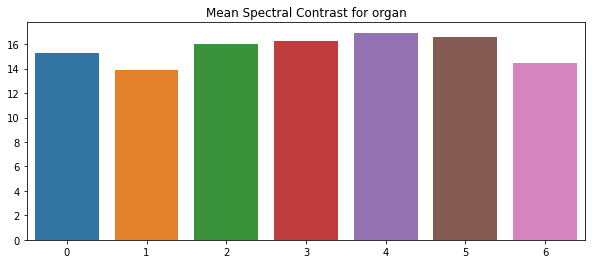

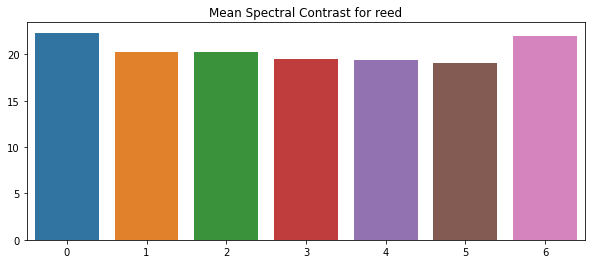

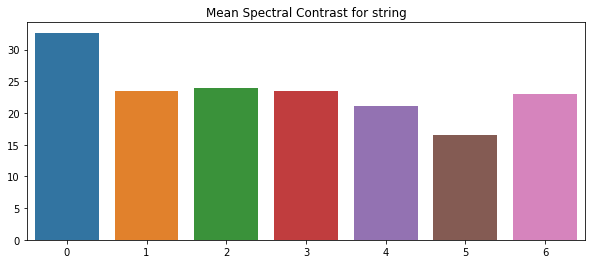

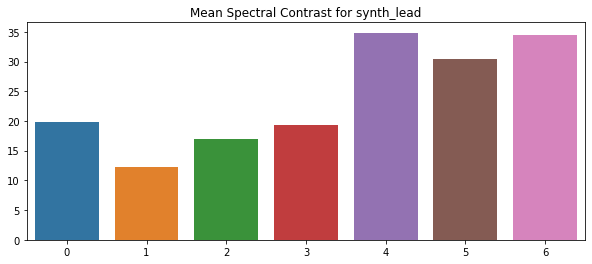

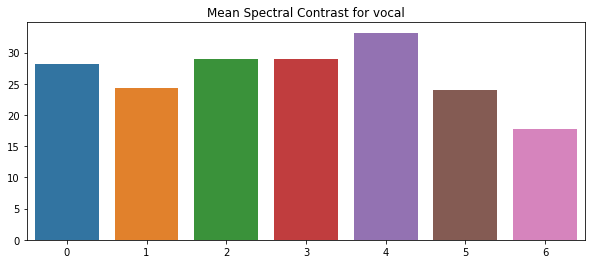

In [38]:
for C, contrast, instrument in zip(contrast_means, contrasts,class_names):
    plt.figure(figsize=(10,4))
    n_constrast= np.arange(0, contrast.shape[0])
    plt.title("Mean Spectral Contrast for " + instrument)
    sns.barplot(x=n_constrast, y= C)

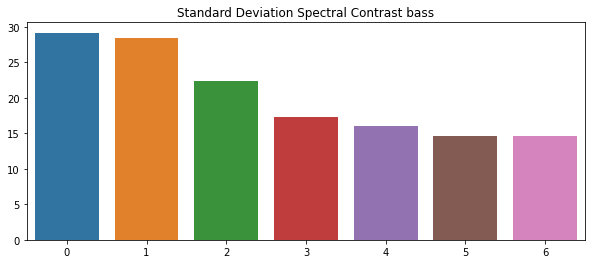

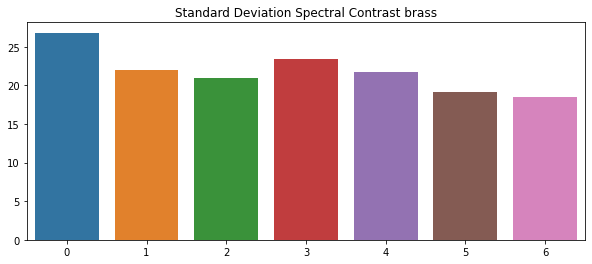

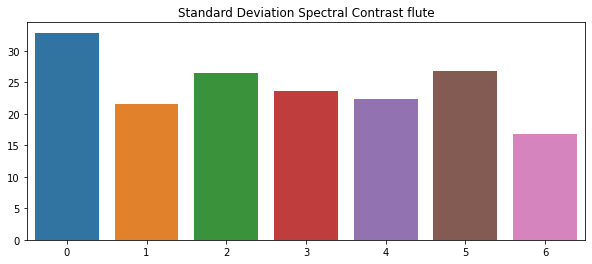

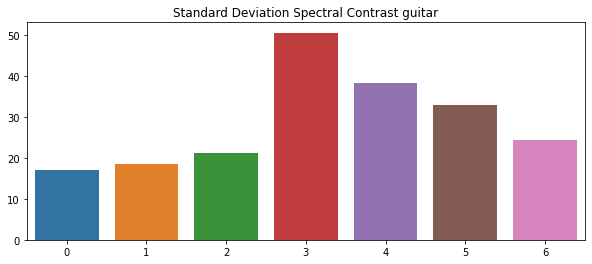

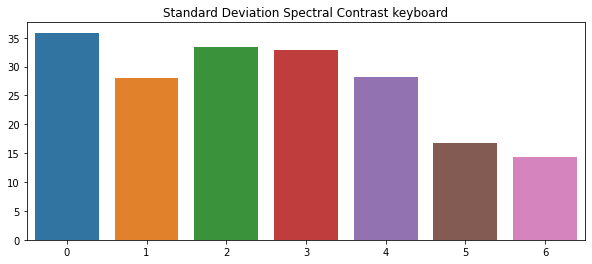

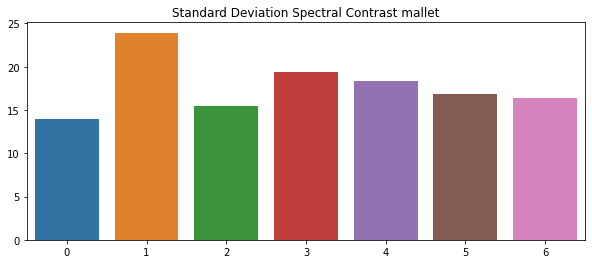

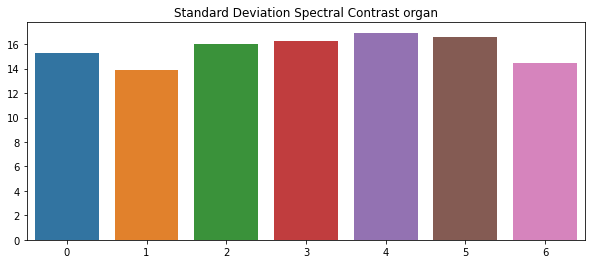

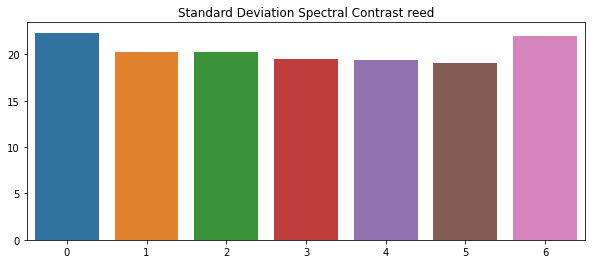

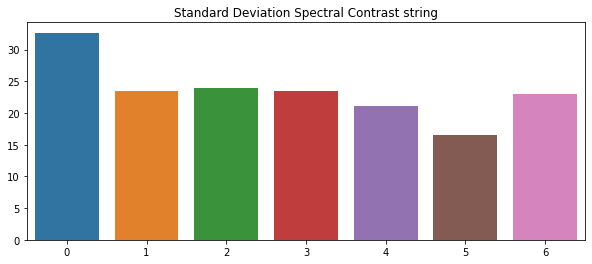

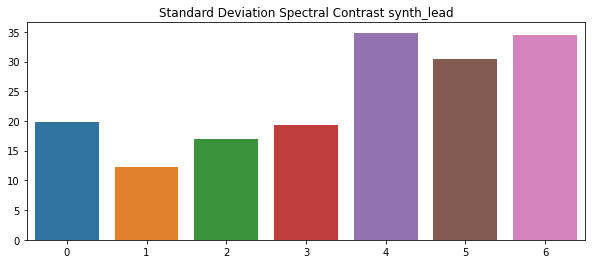

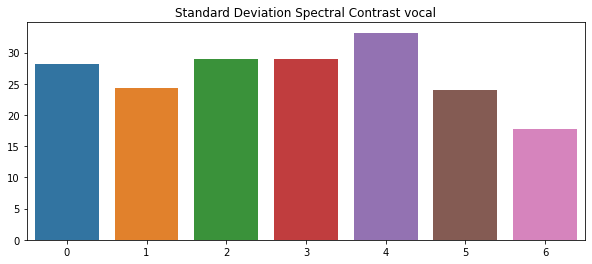

In [39]:
for C, contrast, instrument in zip(contrast_stds, contrasts,class_names):
    plt.figure(figsize=(10,4))
    n_constrast= np.arange(0, contrast.shape[0])
    plt.title("Standard Deviation Spectral Contrast " + instrument)
    sns.barplot(x=n_constrast, y= C)

### Spectral Rolloff Summary

In [40]:
rolloff_means = []
rolloff_stds = []
rolloff_skews = []

for i in range(len(rolloffs)):
    rolloff_means.append(np.mean(rolloffs[i]))
    rolloff_stds.append(np.std(rolloffs[i]))
    rolloff_skews.append(scipy.stats.skew(rolloffs[i], axis=1)[0])
    print("Rolloff mean of {} is {}".format(class_names[i], rolloff_means[i]))
    print("Rolloff standard deviation of {} is ".format(class_names[i], rolloff_stds[i]))
    print("Rolloff skewness of {} is {} \n".format(class_names[i], rolloff_skews[i]))

Rolloff mean of bass is 1369.7916666666667
Rolloff standard deviation of bass is 
Rolloff skewness of bass is 1.801283351746414 

Rolloff mean of brass is 1250.124007936508
Rolloff standard deviation of brass is 
Rolloff skewness of brass is 4.647497111045061 

Rolloff mean of flute is 629.6502976190476
Rolloff standard deviation of flute is 
Rolloff skewness of flute is 5.220431947619361 

Rolloff mean of guitar is 1316.7782738095239
Rolloff standard deviation of guitar is 
Rolloff skewness of guitar is 3.0960350760846564 

Rolloff mean of keyboard is 1048.859126984127
Rolloff standard deviation of keyboard is 
Rolloff skewness of keyboard is 2.954716322345041 

Rolloff mean of mallet is 1706.1631944444443
Rolloff standard deviation of mallet is 
Rolloff skewness of mallet is 1.198133859323095 

Rolloff mean of organ is 154.38988095238096
Rolloff standard deviation of organ is 
Rolloff skewness of organ is -1.3345064168376435 

Rolloff mean of reed is 1091.1458333333333
Rolloff standa

# Zero Crossing Sumarry

In [41]:
z_crossings_means = []
z_crossings_stds = []

for i in range(len(z_crossings)):
    z_crossings_means.append(np.mean(z_crossings[i]))
    z_crossings_stds.append(np.std(z_crossings[i]))
    print("Zero Crossing mean of {} is {}".format(class_names[i], z_crossings_means[i]))
    print("Zero Crossing standard deviation of {} is ".format(class_names[i], z_crossings_stds[i]))

Zero Crossing mean of bass is 2347.0
Zero Crossing standard deviation of bass is 
Zero Crossing mean of brass is 4036.0
Zero Crossing standard deviation of brass is 
Zero Crossing mean of flute is 791.0
Zero Crossing standard deviation of flute is 
Zero Crossing mean of guitar is 7825.0
Zero Crossing standard deviation of guitar is 
Zero Crossing mean of keyboard is 1965.0
Zero Crossing standard deviation of keyboard is 
Zero Crossing mean of mallet is 2306.0
Zero Crossing standard deviation of mallet is 
Zero Crossing mean of organ is 749.0
Zero Crossing standard deviation of organ is 
Zero Crossing mean of reed is 2079.0
Zero Crossing standard deviation of reed is 
Zero Crossing mean of string is 679.0
Zero Crossing standard deviation of string is 
Zero Crossing mean of synth_lead is 17179.0
Zero Crossing standard deviation of synth_lead is 
Zero Crossing mean of vocal is 3495.0
Zero Crossing standard deviation of vocal is 


### Zero Crossing Rate Summary

In [42]:
zrate_means = []
zrate_stds = []
zrate_skews = []

for i in range(len(zrates)):
    zrate_means.append(np.mean(zrates[i]))
    zrate_stds.append(np.std(zrates[i]))
    zrate_skews.append(scipy.stats.skew(zrates[i], axis=1)[0])
    print("Zero Crossing Rate mean of {} is {}".format(class_names[i], zrate_means[i]))
    print("Zero Crossing Rate standard deviation of {} is ".format(class_names[i], zrate_stds[i]))
    print("Zero Crossing Rate skewness of {} is {} \n".format(class_names[i], zrate_skews[i]))

Zero Crossing Rate mean of bass is 0.036318824404761904
Zero Crossing Rate standard deviation of bass is 
Zero Crossing Rate skewness of bass is 2.7654559613963983 

Zero Crossing Rate mean of brass is 0.062286861359126984
Zero Crossing Rate standard deviation of brass is 
Zero Crossing Rate skewness of brass is 2.6083958013305626 

Zero Crossing Rate mean of flute is 0.01220703125
Zero Crossing Rate standard deviation of flute is 
Zero Crossing Rate skewness of flute is 1.0052232919844346 

Zero Crossing Rate mean of guitar is 0.12097361731150794
Zero Crossing Rate standard deviation of guitar is 
Zero Crossing Rate skewness of guitar is -1.6533878860969293 

Zero Crossing Rate mean of keyboard is 0.0303741939484127
Zero Crossing Rate standard deviation of keyboard is 
Zero Crossing Rate skewness of keyboard is 4.258136625008744 

Zero Crossing Rate mean of mallet is 0.03503999255952381
Zero Crossing Rate standard deviation of mallet is 
Zero Crossing Rate skewness of mallet is 2.6709

# LPC Summary

In [43]:
lpc_means = []
lpc_stds = []
lpc_skews = []

for i in range(len(lpcs)):
    lpc_means.append(np.mean(lpcs[i]))
    lpc_stds.append(np.std(lpcs[i]))
    print("Rolloff mean of {} is {}".format(class_names[i], lpc_means[i]))
    print("Rolloff standard deviation of {} is ".format(class_names[i], lpc_stds[i]))

Rolloff mean of bass is 0.006037334445863962
Rolloff standard deviation of bass is 
Rolloff mean of brass is 0.014934837818145752
Rolloff standard deviation of brass is 
Rolloff mean of flute is 0.000726719677913934
Rolloff standard deviation of flute is 
Rolloff mean of guitar is 0.07167188078165054
Rolloff standard deviation of guitar is 
Rolloff mean of keyboard is 0.0018206635722890496
Rolloff standard deviation of keyboard is 
Rolloff mean of mallet is 0.07056094706058502
Rolloff standard deviation of mallet is 
Rolloff mean of organ is 0.0004166761937085539
Rolloff standard deviation of organ is 
Rolloff mean of reed is 0.056306224316358566
Rolloff standard deviation of reed is 
Rolloff mean of string is 0.00048116841935552657
Rolloff standard deviation of string is 
Rolloff mean of synth_lead is 0.21598559617996216
Rolloff standard deviation of synth_lead is 
Rolloff mean of vocal is 0.009947657585144043
Rolloff standard deviation of vocal is 
